In [120]:
import math
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import sys
import six
sys.modules['sklearn.externals.six'] = six
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.metrics import normalized_mutual_info_score, classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, log_loss
from collections import defaultdict, Counter

In [23]:
# nltk.download('stopwords')

## File descriptions

- test_variants - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations)

- test_text - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)

## Loading the variants and text datasets

- **training_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are ID (the id of the row used to link the mutation to the clinical evidence), Gene (the gene where this genetic mutation is located), Variation (the aminoacid change for this mutations), Class (1-9 the class this genetic mutation has been classified on)

In [2]:
# reading training variants file

data = pd.read_csv("training/training_variants") # contains gene, var, and class
print("Number of data points: ", data.shape[0])
print("Number of features: ", data.shape[1])
print("Features: ", data.columns.values)

data.head()

Number of data points:  3321
Number of features:  4
Features:  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


- **training_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)


In [3]:
# reading training text file

data_text = pd.read_csv("training/training_text", sep=("\|\|"),engine="python", names=['ID', 'Text'], skiprows=1)
print("Number of data points: ", data_text.shape[0])
print("Number of features: ", data_text.shape[1])
print("Features: ", data_text.columns.values)
data_text.head()

Number of data points:  3321
Number of features:  2
Features:  ['ID' 'Text']


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
data_text['Text'][0]

"Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

### Preprocessing the text from data_text

In [5]:
stop_words = set(stopwords.words('english')) # gets all the stopwords in english

def text_preprocessing(text, index, column):
    if type(text) is not int:
        string = ""
        # replacing special characters with space ' '
        text = re.sub('[^a-zA-Z0-9\n]', ' ', str(text))
        # replacing multiple spaces with single space
        text = re.sub('\s+', ' ', text)
        #lowercase
        text = text.lower()
        
        for word in text.split():
            # adding words to string that are not in stop words
            if word not in stop_words:
                string += word + " "
                
        data_text.loc[index,column] = string

In [6]:
#to check time for preprocessind the text
start_time = time.perf_counter()
# i, j gives indices and data of rows respectively, i = 0,1,2,...and j = ID- 0, Text- Cyclin-dependent..
for index, row in data_text.iterrows():
    text_preprocessing(row['Text'], index, 'Text')
    
end_time = time.perf_counter()
print('Time took for text preprocessing is ',end_time - start_time, ' seconds')

Time took for text preprocessing is  25.97349836900048  seconds


In [7]:
data_text

,ID,Text
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...
...,...,...
3316,3316,introduction myelodysplastic syndromes mds het...
3317,3317,introduction myelodysplastic syndromes mds het...
3318,3318,runt related transcription factor 1 gene runx1...
3319,3319,runx1 aml1 gene frequent target chromosomal tr...


In [11]:
# mergind data and data_text based on ID

result = pd.merge(data,data_text,on='ID', how='left')
result

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...
...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,introduction myelodysplastic syndromes mds het...
3317,3317,RUNX1,A122*,1,introduction myelodysplastic syndromes mds het...
3318,3318,RUNX1,Fusions,1,runt related transcription factor 1 gene runx1...
3319,3319,RUNX1,R80C,4,runx1 aml1 gene frequent target chromosomal tr...


In [12]:
result[result.isnull().any(axis=1)] # check for Null values

,ID,Gene,Variation,Class,Text


## Train, CV and Test split

In [13]:
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('/s+', '_')
result.Gene = result.Gene.str.replace('/s+', '_')

# splitting result into train and test (80:20)
X_train, X_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

#splitting train into train and cv (64:16)
train_df, cv_df, train_y, cv_y = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [14]:
print("Train data: ",train_df.shape)
print("CV data: ", cv_df.shape)
print("Test data: ", X_test.shape)

Train data:  (2124, 5)
CV data:  (532, 5)
Test data:  (665, 5)


In [15]:
train_dist = train_df['Class'].value_counts().sort_index()
test_dist = X_test['Class'].value_counts().sort_index()
cv_dist = cv_df['Class'].value_counts().sort_index()


<Axes: xlabel='Class'>

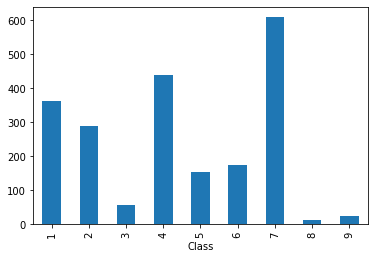

In [16]:
train_dist.plot(kind='bar')

<Axes: xlabel='Class'>

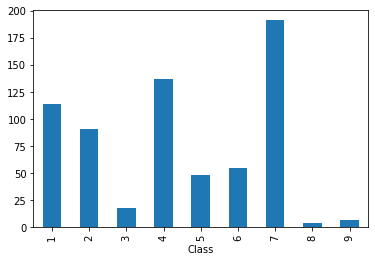

In [17]:

test_dist.plot(kind='bar')

<Axes: xlabel='Class'>

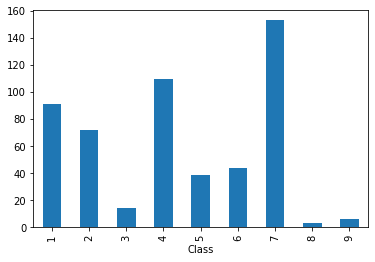

In [18]:
cv_dist.plot(kind='bar')

 From the graphs we can observe that train,cv and test splits have equal distribution of classes

### Simulating a random model

In [107]:
def plot_confusion_matrix(y_test, y_pred):
    # confusion matrix
    C = confusion_matrix(y_test, y_pred)
    
    #precision matrix
    P = (C/C.sum(axis=0))
    
    # recall matrix
    R = ((C.T / C.sum(axis=1)).T)
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,8))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(10,8))
    sns.heatmap(P, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(10,8))
    sns.heatmap(R, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Logloss on CV dataset:  2.420340895264814
Logloss on Test dataset:  2.4606151991098097
-------------------- Confusion matrix --------------------


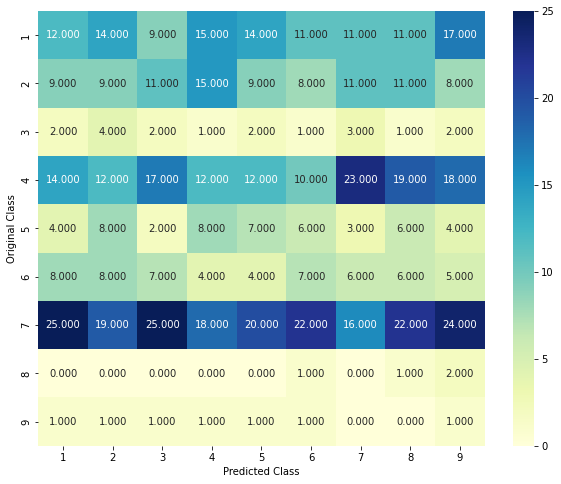

-------------------- Precision matrix (Columm Sum=1) --------------------


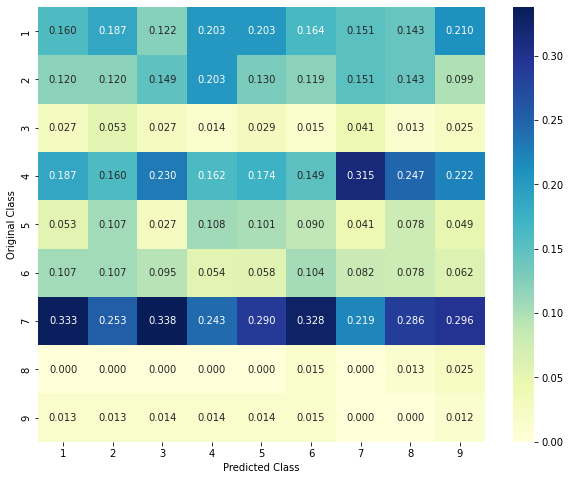

-------------------- Recall matrix (Row sum=1) --------------------


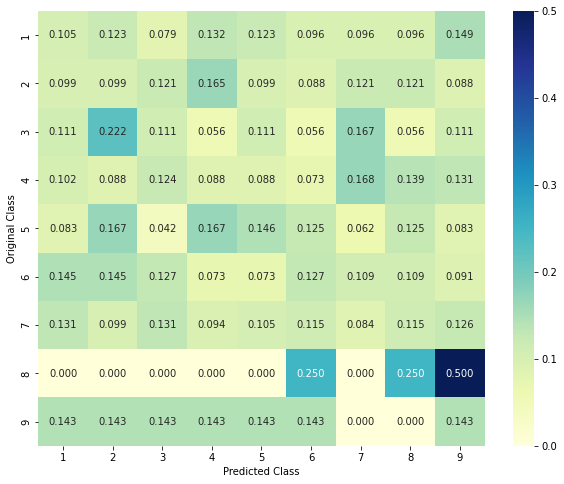

In [20]:
cv_data_len = cv_df.shape[0]
test_data_len = X_test.shape[0]

#random model predicted cv_y
cv_random_y = np.zeros((cv_data_len, 9))
for i in range(cv_data_len):
    rand_prob = np.random.rand(1,9)
    cv_random_y[i] = ((rand_prob/sum(sum(rand_prob)))[0])

print("Logloss on CV dataset: ", log_loss(cv_y, cv_random_y))

# random model predicted test_y
test_random_y = np.zeros((test_data_len, 9))
for i in range(test_data_len):
    rand_prob = np.random.rand(1,9)
    test_random_y[i] = ((rand_prob/sum(sum(rand_prob)))[0])

print("Logloss on Test dataset: ", log_loss(y_test, test_random_y))    

# retreiving the class with highest prob in test_random_y
y_pred = np.argmax(test_random_y, axis=1)
#plotting confusion matrix
plot_confusion_matrix(y_test, y_pred+1)


## Univariate analysis

Analysing each feature to check if we can predict $y_i$ using only $x_i$

- What type of feature is it (numerical ,categorical, text, image)
- How many  Unique values are present
- How to featurize the values (OneHot or Response encoding)
- Are the features stable across all the data sets (Train, CV, Test)




### Response encoding

- Technqiue used to convert text/categorical variables into numericals.
- Response encoding converts a feature into a vector of size n (#classes)
- Where, each value in the vector represents the probability of data point belonging to class i ($y_i$) given it also belongs to feature j ($x_i$)

$$ f_i = {P(y_i | x_i)} = {P(y_i \& x_i) \over P(x_i)} $$

- Since, there might be cases of zero probability, we use laplace smoothing for overcoming it.

$$ f_i = {{P(y_i \& x_i) + 10 * \alpha } \over {P(x_i) + 90 * \alpha}} $$

- For all the values that are present in train_df, we replace $x_i$ with the probability vector,whereas for CV and test data set, we set the values to [1/9, 1/9, 1/9, 1/9, 1/9...1/9]
- We cannot use response encoding on test and CV data, because it causes response leakage, so we use it only on train data.

In [21]:
# reponse encoding

# for features in train_df

def get_feat_dict(alpha, feature, df):
    feature_dict = dict()
    value_count = train_df[feature].value_counts()
    
    for i, feature_count in value_count.items():
        vector = []
        for k in range(1,10):
            class_feat_count = train_df.loc[(train_df[feature] == i) & (train_df['Class'] == k)] 
            vector.append((class_feat_count.shape[0] + 10*alpha) / (feature_count + 90*alpha))
        
        feature_dict[i] = vector
        
    return feature_dict


def get_feat(alpha, feature, df):
    feature_dict = get_feat_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    feature_vect = []
    for index,row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            feature_vect.append(feature_dict[row[feature]])
        else:
            feature_vect.append([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
            
    return feature_vect
        

## Univariate analysis on Gene Feature

- Categorical feature

In [146]:
# Histogram plot
def plot_histogram(features, feature_name):
    s = sum(features.values)
    h = features.values/s
    plt.plot(h, label='Histogram of '+ feature_name)
    plt.xlabel('Index of '+ feature_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()

In [148]:
# Cummulative probabilty plot
def plot_cdf(features, feature_name):
    s = sum(features.values)
    h = features.values/s
    c = np.cumsum(h)
    plt.plot(c, label="Cummulative distribution of "+ feature_name)
    plt.grid()
    plt.legend()
    plt.show()
   

In [22]:
train_df['Gene'] # categorical variable

969       ESR1
1911     FOXP1
1509       ALK
2392    PTPN11
810      ERCC2
         ...  
579      SMAD4
1955       ATM
2307      JAK1
77       CCND3
1861      MTOR
Name: Gene, Length: 2124, dtype: object

In [23]:
unique_genes = train_df['Gene'].value_counts()
unique_genes.shape # number of unique values

(230,)

In [24]:
unique_genes

Gene
BRCA1    170
TP53      96
EGFR      95
PTEN      89
BRCA2     79
        ... 
CTLA4      1
AURKB      1
BRD4       1
RAB35      1
MDM2       1
Name: count, Length: 230, dtype: int64

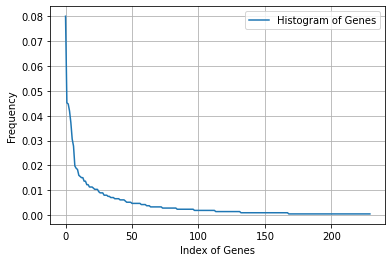

In [147]:
plot_histogram(unique_genes,"Genes")# grpah shows only top 10 values occur more frequently

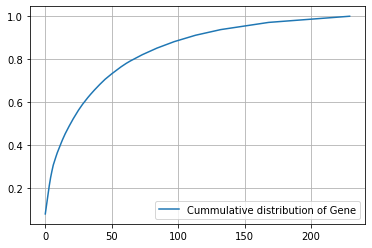

In [149]:
plot_cdf(unique_genes, "Gene")# top 50 contribute to almost 70% of the data

### Response Encoding on Gene feature'


In [27]:
# response encoding on 'Gene' feature

alpha = 1

train_gene_rc = np.array(get_feat(alpha,"Gene",train_df))
cv_gene_rc = np.array(get_feat(alpha, "Gene", cv_df))
test_gene_rc = np.array(get_feat(alpha, "Gene", X_test))


In [28]:
train_gene_rc.shape

(2124, 9)

In [29]:
train_y.shape

(2124,)

In [30]:
train_gene_rc

array([[0.0990099 , 0.11881188, 0.11881188, ..., 0.16831683, 0.0990099 ,
        0.0990099 ],
       [0.13043478, 0.10869565, 0.10869565, ..., 0.10869565, 0.10869565,
        0.10869565],
       [0.07751938, 0.10852713, 0.12403101, ..., 0.27906977, 0.07751938,
        0.07751938],
       ...,
       [0.10576923, 0.09615385, 0.09615385, ..., 0.22115385, 0.09615385,
        0.09615385],
       [0.10526316, 0.13684211, 0.10526316, ..., 0.12631579, 0.10526316,
        0.10526316],
       [0.08403361, 0.12605042, 0.1512605 , ..., 0.21008403, 0.08403361,
        0.08403361]])

### One Hot encoding on Gene feature

In [31]:
# OneHot encoding of Gene feature
oneHot = CountVectorizer()

train_gene_onehot = oneHot.fit_transform(train_df['Gene'])
cv_gene_onehot = oneHot.transform(cv_df['Gene'])
test_gene_onehot = oneHot.transform(X_test['Gene'])


In [32]:
cv_gene_onehot.shape

(532, 229)

In [33]:
oneHot.get_feature_names_out()

array(['abl1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc', 'ar', 'araf',
       'arid1b', 'arid2', 'asxl1', 'asxl2', 'atm', 'atr', 'atrx', 'aurka',
       'aurkb', 'axl', 'b2m', 'bap1', 'bcl10', 'bcor', 'braf', 'brca1',
       'brca2', 'brd4', 'brip1', 'btk', 'card11', 'carm1', 'casp8', 'cbl',
       'ccnd1', 'ccnd3', 'cdh1', 'cdk12', 'cdk6', 'cdk8', 'cdkn1a',
       'cdkn1b', 'cdkn2a', 'cdkn2b', 'cebpa', 'chek2', 'cic', 'crebbp',
       'ctcf', 'ctla4', 'ctnnb1', 'ddr2', 'dicer1', 'dnmt3a', 'dnmt3b',
       'egfr', 'elf3', 'ep300', 'epas1', 'epcam', 'erbb2', 'erbb3',
       'erbb4', 'ercc2', 'ercc3', 'ercc4', 'erg', 'esr1', 'etv1', 'etv6',
       'ewsr1', 'ezh2', 'fam58a', 'fanca', 'fat1', 'fbxw7', 'fgf19',
       'fgf4', 'fgfr1', 'fgfr2', 'fgfr3', 'fgfr4', 'flt1', 'flt3',
       'foxa1', 'foxl2', 'foxp1', 'gata3', 'gli1', 'gna11', 'gnaq',
       'gnas', 'h3f3a', 'hist1h1c', 'hla', 'hnf1a', 'hras', 'idh1',
       'idh2', 'igf1r', 'il7r', 'jak1', 'jak2', 'jun', 'kdm5c', 'kdm6a',
    

### Calculate log_loss for univariate

In [300]:
alpha = [10**x for x in range(-5,1)] # alpha = 0.00001,0.0001,0.001,0.01,0.1,1,10

def plot_errors(alpha, cv_log_error):
    fig,ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_log_error, c='b')
    for i, txt in enumerate(np.round(cv_log_error, 3)):
        ax.annotate((alpha[i], np.round(txt, 3)), (np.log10(alpha[i]), cv_log_error[i]))
    plt.grid()
    plt.title('Cross Validation error for each alpha')
    plt.xlabel('Alpha values')
    plt.ylabel('Error')
    plt.show()

def train_model(alpha, clf, train_feat, cv_feat, test_feat, return_value):
    cv_log_error = []
    for i in alpha:
        clf.alpha=i
        clf.fit(train_feat, train_y)
        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(train_feat, train_y)
        predict_y = sig_clf.predict_proba(cv_feat)
        cv_log_error.append(log_loss(cv_y, predict_y, labels=clf.classes_))
        if return_value==None:
            print('For alpha = ', i, ', log loss is: ', log_loss(cv_y, predict_y, labels=clf.classes_))

    if return_value==None:
        plot_errors(alpha, cv_log_error)

    best_alpha = np.argmin(cv_log_error)
    clf.alpha= alpha[best_alpha]
    clf.fit(train_feat, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_feat, train_y)

    if return_value==None:
        print("For best alpha value = ", alpha[best_alpha])
        predict_y = sig_clf.predict_proba(train_feat)
        print("Train log loss is: ", log_loss(train_y, predict_y, labels=clf.classes_))
        predict_y = sig_clf.predict_proba(cv_feat)
        print("CV log loss is: ", log_loss(cv_y, predict_y, labels=clf.classes_))
        predict_y = sig_clf.predict_proba(test_feat)
        print("Test log loss is: ", log_loss(y_test, predict_y, labels=clf.classes_))

    if return_value!= None:
        return best_alpha

### Training on a model to check how good is the 'Gene' Feature for predicting y_i

For alpha =  1e-05 , log loss is:  1.2154519302016353
For alpha =  0.0001 , log loss is:  1.2111913074395113
For alpha =  0.001 , log loss is:  1.2630654114674116
For alpha =  0.01 , log loss is:  1.3690270173552768
For alpha =  0.1 , log loss is:  1.459091337904096
For alpha =  1 , log loss is:  1.4993290198590112


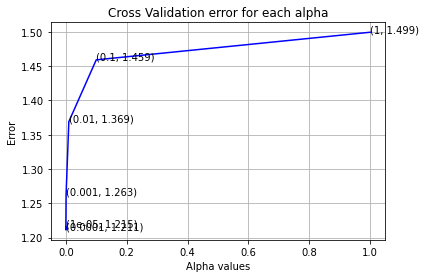

For best alpha value =  0.0001
Train log loss is:  0.981893961129082
CV log loss is:  1.2111913074395113
Test log loss is:  1.1883899691270334


In [35]:
# onehot encoded 
clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss',random_state=42)
train_model(alpha, clf, train_gene_onehot, cv_gene_onehot, test_gene_onehot, return_value=True)

For alpha =  1e-05 , log loss is:  1.2933406866272907
For alpha =  0.0001 , log loss is:  1.3181503993506494
For alpha =  0.001 , log loss is:  1.3619032652105512
For alpha =  0.01 , log loss is:  1.3868239491150223
For alpha =  0.1 , log loss is:  1.3910237736792512
For alpha =  1 , log loss is:  1.389095589489993


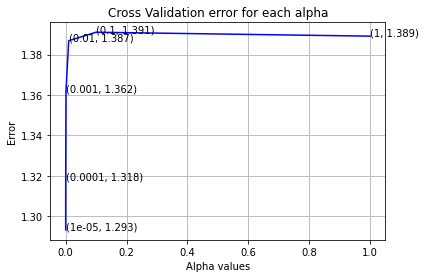

For best alpha value =  1e-05
Train log loss is:  1.1739931241612598
CV log loss is:  1.2933406866272907
Test log loss is:  1.2776175853733838


In [36]:
# response encoded
clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss',random_state=42)
train_model(alpha, clf, train_gene_rc, cv_gene_rc, test_gene_rc, return_value=True)

- OneHot encoded has less log-loss compared to response encoded

### Stability of the Gene feature across all datasets (Train, CV, Test)

In [37]:
# check how many values in test['Gene'] and cv['Gene'] are present in train['Gene']

test_subset = X_test[X_test["Gene"].isin(list(set(train_df['Gene'])))] # isin() to check if value is present in the lst
cv_subset = cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))]

print('Test data contains ', np.round((test_subset.shape[0]/y_test.shape[0])*100, 4), ' % data from train dataset')
print('CV data contains ', np.round((cv_subset.shape[0]/cv_y.shape[0])*100, 4), ' % data from train dataset')

Test data contains  96.5414  % data from train dataset
CV data contains  96.0526  % data from train dataset


- This shows that 'Gene' feature is stable across all datasets.
- Higher the intersection percent, higher the stability

## Univariate analysis on Variation Feature

- Categorical variable

In [38]:
train_df['Variation'] # categorical variable

969         ESR1-YAP1 Fusion
1911    Truncating Mutations
1509                  T1151M
2392                    Y62C
810                    D609E
                ...         
579                    D537Y
1955                Deletion
2307                   V658F
77                     Q276*
1861                  I2500F
Name: Variation, Length: 2124, dtype: object

In [39]:
unique_variations = train_df['Variation'].value_counts()
unique_variations.shape # number of unique variation values

(1928,)

In [40]:
unique_variations # frequency of each unique variation

Variation
Truncating Mutations    63
Amplification           43
Deletion                39
Fusions                 24
Q61R                     3
                        ..
F53C                     1
Y1295A                   1
R132C                    1
Q233*                    1
I2500F                   1
Name: count, Length: 1928, dtype: int64

In [41]:
print("Number of variations: ", sum(unique_variations)) # totalnumber of variation values( # datapoints)
print("Number of unique variations: ", unique_variations.count()) # gives number of unique variations

Number of variations:  2124
Number of unique variations:  1928


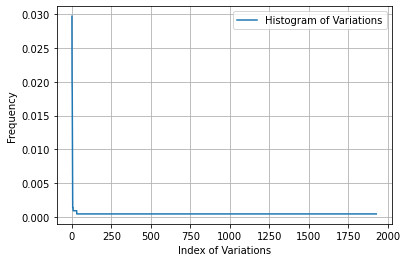

In [150]:
#histogram plot
    
plot_histogram(unique_variations, "Variations")   # grph shows only 2-3 variations have high frequency that contribute to majority of count 

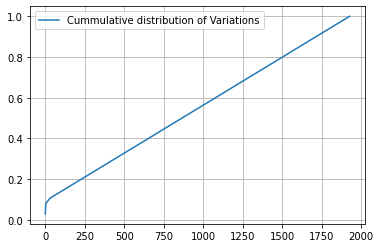

In [151]:
# CDF plot
plot_cdf(unique_variations, "Variations")# linear grpah shows most of the values are occuring either once or twice

### Response Enoding on 'Variation' feature

In [44]:
# response encoding on 'Variation' feature

alpha = 1

train_var_rc = np.array(get_feat(alpha,"Variation",train_df))
cv_var_rc = np.array(get_feat(alpha, "Variation", cv_df))
test_var_rc = np.array(get_feat(alpha, "Variation", X_test))


In [45]:
train_var_rc.shape

(2124, 9)

In [46]:
train_var_rc

array([[0.10989011, 0.10989011, 0.10989011, ..., 0.12087912, 0.10989011,
        0.10989011],
       [0.45751634, 0.07189542, 0.06535948, ..., 0.06535948, 0.06535948,
        0.06535948],
       [0.10989011, 0.10989011, 0.10989011, ..., 0.10989011, 0.10989011,
        0.10989011],
       ...,
       [0.10989011, 0.10989011, 0.10989011, ..., 0.12087912, 0.10989011,
        0.10989011],
       [0.10989011, 0.10989011, 0.10989011, ..., 0.12087912, 0.10989011,
        0.10989011],
       [0.10989011, 0.10989011, 0.10989011, ..., 0.12087912, 0.10989011,
        0.10989011]])

### OneHot encoding on 'Variation'

In [47]:
# onehot encoding 

train_var_onehot = oneHot.fit_transform(train_df['Variation'])
cv_var_onehot = oneHot.transform(cv_df['Variation'])
test_var_onehot = oneHot.transform(X_test['Variation'])


In [48]:
train_var_onehot.shape

(2124, 1959)

### Training on a model to check how good is the 'Variation' Feature for predicting y_i

For alpha =  1e-05 , log loss is:  1.6819797133809138
For alpha =  0.0001 , log loss is:  1.6734729908328299
For alpha =  0.001 , log loss is:  1.6819846366490903
For alpha =  0.01 , log loss is:  1.6941606891825318
For alpha =  0.1 , log loss is:  1.6992543422955915
For alpha =  1 , log loss is:  1.7030882571738988


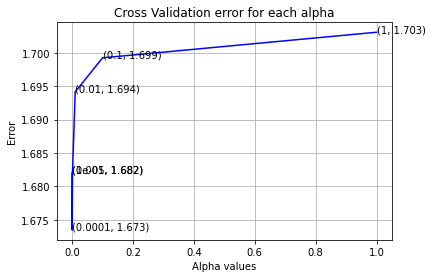

For best alpha value =  0.0001
Train log loss is:  0.7138619279350616
CV log loss is:  1.6734729908328299
Test log loss is:  1.7033203631402847


In [49]:
# one hot encoded
alpha = [10**i for i in range(-5,1)]
check_feature(alpha, train_var_onehot, cv_var_onehot, test_var_onehot, return_value=None)

For alpha =  1e-05 , log loss is:  2.032793815902697
For alpha =  0.0001 , log loss is:  2.021845267120055
For alpha =  0.001 , log loss is:  1.978302857130956
For alpha =  0.01 , log loss is:  1.9184584494843615
For alpha =  0.1 , log loss is:  1.8972183803058296
For alpha =  1 , log loss is:  1.8201609826176082


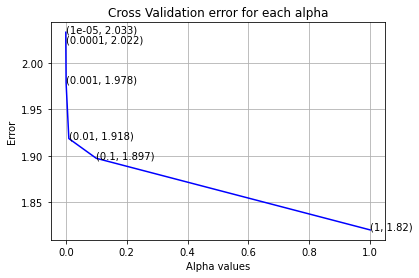

For best alpha value =  1
Train log loss is:  0.8061946918614881
CV log loss is:  1.8201609826176082
Test log loss is:  1.8693487150559853


In [50]:
# response encoded

check_feature(alpha, train_var_rc, cv_var_rc, test_var_rc, return_value=None)

- OneHot encoded usually has less log-loss comapred to response encoding
- Variation feature give low variance(good accuracy for train) and high bias(bad accuracy for test)

### Stability of the Variation feature across all datasets (Train, CV, Test)

In [52]:
# check how many values in test['Variation'] and cv['Variation'] are present in train['Variation']

test_subset = X_test[X_test["Variation"].isin(list(set(train_df['Variation'])))] # isin() to check if value is present in the lst
cv_subset = cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))]

print('Test data contains ', np.round((test_subset.shape[0]/y_test.shape[0])*100, 4), ' % data from train dataset')
print('CV data contains ', np.round((cv_subset.shape[0]/cv_y.shape[0])*100, 4), ' % data from train dataset')

Test data contains  9.7744  % data from train dataset
CV data contains  11.0902  % data from train dataset


- This shows that variation feature is not stable across the datasets

### Univariate analysis on Text feature

In [53]:
# count frequency of each word from each row in 'TEXT' feature

def word_count(text):
    word_dict = defaultdict(int)
    for index, row in text.iterrows():
        for word in row['Text'].split():
            word_dict[word] += 1  
    return word_dict

def get_text_rc(df):
    text_rc = np.zeros((df.shape[0], 9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10)/(total_dict.get(word, 0)+90)))
            text_rc[row_index][i] = math.exp(sum_prob/len(row['Text'].split()))
            row_index += 1
    return text_rc

dict_list = [] # list of 9 dictionaries for each classes, containing each word and its frequency

for i in range(1,10):
    class_text = train_df[train_df['Class']==i]
    dict_list.append(word_count(class_text)) # word freq of class i
    
total_dict = word_count(train_df)# word freq for total dataset

### Response encoding on text feature

In [55]:
# response encoding on text feature

train_text_rc = get_text_rc(train_df)
cv_text_rc = get_text_rc(cv_df)
test_text_rc = get_text_rc(X_test)


In [56]:
train_text_rc #before normalization

array([[0.13092955, 0.14378819, 0.02599115, ..., 0.32828373, 0.0118262 ,
        0.02183513],
       [0.16509444, 0.10617496, 0.01644398, ..., 0.30230829, 0.00961564,
        0.01669033],
       [0.09806677, 0.12569831, 0.0293167 , ..., 0.36723642, 0.00872697,
        0.01478826],
       ...,
       [0.11264638, 0.10548226, 0.02159594, ..., 0.38812205, 0.00899851,
        0.01598431],
       [0.13460752, 0.14122486, 0.02212999, ..., 0.30765318, 0.01171692,
        0.02298446],
       [0.11641177, 0.13510411, 0.0351453 , ..., 0.35759841, 0.00931484,
        0.0173263 ]])

In [57]:
# normalizing each row such that they sum upto 1

train_text_rc = (train_text_rc.T/train_text_rc.sum(axis=1)).T
cv_text_rc = (cv_text_rc.T/cv_text_rc.sum(axis=1)).T
test_text_rc = (test_text_rc.T/test_text_rc.sum(axis=1)).T

In [58]:
train_text_rc #after normalization

array([[0.1459309 , 0.16026283, 0.02896911, ..., 0.36589708, 0.01318119,
        0.02433691],
       [0.1888704 , 0.12146568, 0.01881215, ..., 0.34584503, 0.01100044,
        0.01909398],
       [0.11579732, 0.14842466, 0.03461718, ..., 0.43363304, 0.01030482,
        0.01746199],
       ...,
       [0.12882273, 0.12062981, 0.02469718, ..., 0.44385749, 0.01029072,
        0.0182797 ],
       [0.14940049, 0.15674506, 0.02456202, ..., 0.34146336, 0.01300457,
        0.02551038],
       [0.12875472, 0.14942898, 0.0388717 , ..., 0.39551399, 0.01030248,
        0.01916338]])

In [68]:
train_text_rc.shape

(2124, 9)

### One Hot encoding on Text feature

In [59]:
# onehot encoding on text feature

text_vectorizer = CountVectorizer(min_df=3) # atleast 3 count
train_text_onehot = text_vectorizer.fit_transform(train_df['Text'])
train_text_features = text_vectorizer.get_feature_names_out() #gives all unique words
train_text_count = train_text_onehot.sum(axis=0).A1 # sum every row and give (1* number of words) vector (count of each word)
text_dict = dict(zip(list(train_text_features), train_text_count)) # map each word with its frequency

In [60]:
train_text_features # unique words list

array(['00', '000', '0000', ..., 'zytomed', 'zytovision', 'zz'],
      dtype=object)

In [61]:
train_text_onehot.sum(axis=0)

matrix([[2389, 5464,   11, ...,    6,    7,   23]])

In [62]:
train_text_count # the frequency of each word from train_text_features list

array([2389, 5464,   11, ...,    6,    7,   23])

In [63]:
len(train_text_features) # number of unique words

53368

In [64]:
text_dict # word: count

{'00': 2389,
 '000': 5464,
 '0000': 11,
 '00000001': 8,
 '0000001': 9,
 '000001': 22,
 '000002': 10,
 '000007': 10,
 '000009': 3,
 '00001': 16,
 '000011': 5,
 '0000112': 3,
 '000012': 5,
 '000017': 5,
 '0000208': 6,
 '00003': 3,
 '00005': 7,
 '000059': 7,
 '0000614': 6,
 '0000645': 3,
 '00006559': 3,
 '000077': 65,
 '0000839': 3,
 '0001': 1487,
 '0001042': 6,
 '0001171': 3,
 '000132': 15,
 '000141': 8,
 '00016': 5,
 '000179': 12,
 '000182': 4,
 '0001a': 18,
 '0002': 130,
 '0002050': 3,
 '0002079': 3,
 '0002158': 10,
 '000245': 17,
 '000249': 16,
 '00025': 3,
 '000251': 14,
 '000258': 18,
 '000264': 3,
 '000267': 47,
 '00028': 5,
 '00029': 6,
 '0003': 87,
 '0003073': 3,
 '000314': 3,
 '0003254': 3,
 '00034': 3,
 '0003529': 3,
 '000369266': 35,
 '00037': 3,
 '0004': 62,
 '0004376': 3,
 '0004798': 3,
 '0004920': 3,
 '0005': 67,
 '0005044': 3,
 '0005159': 3,
 '0005214': 3,
 '0005266': 3,
 '0005309': 3,
 '000535': 11,
 '0005355': 3,
 '000546': 12,
 '000548': 73,
 '000588': 18,
 '0006': 42,


In [65]:
## probabilities of each word given a class

class_word_freq = [] 
for i in train_text_features:
    ratios = []
    for j in range(0,9):
        ratios.append((dict_list[j][i] + 10) / (total_dict[i] + 90))
    class_word_freq.append(ratios)
class_word_freq = np.array(class_word_freq)


In [69]:
class_word_freq.shape # prob of each word belonging to a class

(53368, 9)

In [73]:
#normalizing train_text_onehot data
train_text_onehot = normalize(train_text_onehot, axis=0)

#onehot encoding and normaliing CV data
cv_text_onehot = text_vectorizer.transform(cv_df['Text'])
cv_text_onehot = normalize(cv_text_onehot, axis=0)

# for test data
test_text_onehot = text_vectorizer.transform(X_test['Text'])
test_text_onehot = normalize(test_text_onehot, axis=0)


In [79]:
# sorting the word dict based on word freuqncy in desc order
sorted_text_dict = dict(sorted(text_dict.items(), key=lambda x: x[1], reverse=True))
sorted_text_freq = np.array(list(sorted_text_dict.values()))

In [80]:
sorted_text_dict # word with freq in desc order

{'mutations': 153935,
 'cells': 118314,
 'cell': 80938,
 'mutation': 68337,
 'et': 68182,
 'al': 68118,
 'fig': 65953,
 'cancer': 65055,
 'figure': 62622,
 'patients': 56984,
 'protein': 54064,
 'activity': 49898,
 'expression': 49468,
 'mutant': 47742,
 'type': 46917,
 'tumor': 44202,
 'also': 42641,
 'domain': 42538,
 'variants': 41979,
 'kinase': 41887,
 'binding': 40708,
 'brca1': 40364,
 'using': 39944,
 'gene': 39460,
 'data': 38258,
 'egfr': 37274,
 'analysis': 37214,
 'wild': 36902,
 'dna': 36366,
 '10': 36020,
 'mutants': 33992,
 'tumors': 33529,
 'two': 33529,
 'table': 33481,
 'activation': 32355,
 'may': 31719,
 'results': 29510,
 'ras': 29133,
 'shown': 28310,
 'proteins': 26306,
 'one': 26234,
 'genes': 25967,
 'exon': 25692,
 'associated': 25458,
 'p53': 25086,
 'human': 24687,
 'kit': 24515,
 'used': 24466,
 'identified': 24436,
 'growth': 24101,
 'study': 24021,
 'found': 23845,
 'function': 23503,
 'clinical': 22362,
 '20': 22187,
 'signaling': 22098,
 'levels': 21932

In [81]:
sorted_text_freq #word frequencies

array([153935, 118314,  80938, ...,      3,      3,      3])

In [82]:
print(Counter(sorted_text_freq)) # count: number of words that occur count times

Counter({3: 5077, 4: 3841, 6: 2871, 5: 2816, 8: 2066, 9: 2064, 7: 1852, 10: 1576, 11: 1246, 12: 1236, 14: 937, 13: 887, 18: 790, 15: 751, 20: 710, 16: 691, 17: 620, 24: 589, 21: 505, 19: 477, 22: 447, 30: 396, 28: 386, 26: 377, 27: 371, 25: 370, 37: 341, 23: 333, 29: 328, 36: 289, 31: 278, 33: 270, 32: 256, 52: 250, 40: 250, 35: 250, 38: 239, 34: 217, 42: 211, 43: 203, 45: 197, 41: 195, 39: 188, 48: 184, 50: 178, 47: 171, 46: 169, 44: 156, 53: 148, 60: 144, 54: 144, 49: 142, 51: 138, 55: 135, 56: 131, 57: 130, 65: 128, 58: 127, 64: 117, 63: 115, 66: 111, 61: 111, 72: 107, 59: 106, 62: 104, 76: 99, 69: 99, 67: 98, 77: 93, 68: 92, 79: 89, 75: 89, 74: 86, 70: 86, 73: 85, 86: 83, 85: 82, 80: 79, 78: 77, 84: 76, 89: 73, 81: 72, 88: 71, 93: 70, 71: 70, 108: 68, 83: 68, 87: 66, 82: 65, 98: 62, 90: 62, 112: 61, 100: 60, 99: 60, 92: 60, 104: 56, 91: 56, 120: 55, 124: 54, 117: 52, 106: 52, 97: 52, 101: 50, 115: 49, 114: 49, 111: 49, 102: 49, 96: 49, 95: 49, 105: 48, 122: 47, 113: 46, 110: 46, 12

### Training on a model to check how good is the 'Text' feature for predicting y_i

For alpha =  1e-05 , log loss is:  1.2959546591060072
For alpha =  0.0001 , log loss is:  1.1954316801035447
For alpha =  0.001 , log loss is:  1.2152530625278433
For alpha =  0.01 , log loss is:  1.3273359936074896
For alpha =  0.1 , log loss is:  1.5113378414048506
For alpha =  1 , log loss is:  1.6774421735360707


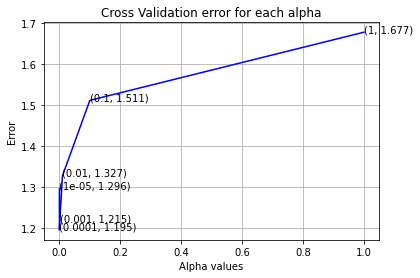

For best alpha value =  0.0001
Train log loss is:  0.6551051787708713
CV log loss is:  1.1954316801035447
Test log loss is:  1.1429133907561164


In [83]:
#one hot encoded
check_feature(alpha, train_text_onehot, cv_text_onehot, test_text_onehot)

For alpha =  1e-05 , log loss is:  1.2240897582153545
For alpha =  0.0001 , log loss is:  1.2414898477490823
For alpha =  0.001 , log loss is:  1.3424164151737892
For alpha =  0.01 , log loss is:  1.3942075113312384
For alpha =  0.1 , log loss is:  1.4110037648355513
For alpha =  1 , log loss is:  1.4396290281848454


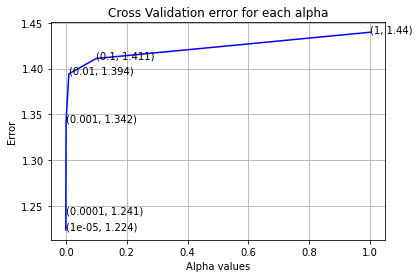

For best alpha value =  1e-05
Train log loss is:  0.8658852955960787
CV log loss is:  1.2240897582153545
Test log loss is:  1.1998608432387714


In [84]:
# response encoded
check_feature(alpha, train_text_rc, cv_text_rc, test_text_rc)

- The model shows low bias and high variance

### Stability of text feature across datasets

In [101]:
def get_common_words(df):
    df_text_vec = CountVectorizer(min_df=3) 
    df_text = df_text_vec.fit_transform(df['Text'])
    df_text_features = df_text_vec.get_feature_names_out() #get the words from df by onehot encoding
    
    df_text_count = df_text.sum(axis=0).A1 # count freq of each word
    df_text_dict = dict(zip(list(df_text_features), df_text_count)) #map words: count
    total_count = len(set(df_text_features)) # number of words from df
    common_count = len(set(train_text_features) & set(df_text_features)) #common words from train and df
    return total_count, common_count

In [102]:
#For CV data
total_count, common_count = get_common_words(cv_df)
print("CV data contains ", np.round((common_count/total_count)*100, 3), "% of words from train dataset")

# For test data
total_count, common_count = get_common_words(X_test)
print("Test data contains ", np.round((common_count/total_count)*100, 3), "% of words from train dataset")

CV data contains  96.836 % of words from train dataset
Test data contains  96.333 % of words from train dataset


- The 'Text' feature is stable across all datasets

### Preparing Data for ML models 

In [277]:
# performance metrics report functions

def predict_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)
 
    print("Log loss: ", log_loss(test_y, sig_clf.predict_proba(test_x)))
    print("Numbero of misclassified points: ", np.count_nonzero((pred_y - test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)
    
def report_log_loss(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x,train_y)
    sig_clf_probs = sig_clg.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=e-15)

In [251]:
#based on top no_features get the features names that are rsponsible for the predicted class
def get_imp_feature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df = 3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['Text'])
    
    gene_len = len(gene_vec.get_feature_names_out()) # num of onehot gene values 
    var_len = len(var_vec.get_feature_names_out()) # num of onehot var values
    
    word_present = 0
    for i, v in enumerate(indices):
        if v < gene_len: #feature is Gene type
            word = gene_vec.get_feature_names_out()[v] #find out the gene corresponding to index
            if word==gene: #check with predicted gene
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word, True))
        elif (v < gene_len+var_len): # feature is Variation, we consider from gene_count value
            word = var_vec.get_feature_names_out()[v - (gene_len)]
            if word==var: #check with predicted variation 
                word_present += 1
                print(i, "Variation feature [{}] present in test data point [{}]".format(word, True))
        else:
            word = text_vec.get_feature_names_out()[v - (gene_len + var_len)]
            if word in text.split():
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word, True))
                
    print("Out of the top ", no_features, " features ", word_present, " are present in test data point")

### Stacking gene,var and text features together



In [122]:
# stacking onehot encoded features
train_gene_var_onehot = hstack((train_gene_onehot, train_var_onehot))
cv_gene_var_onehot = hstack((cv_gene_onehot, cv_var_onehot))
test_gene_var_onehot = hstack((test_gene_onehot, test_var_onehot))

train_x_onehot = hstack((train_gene_var_onehot, train_text_onehot)).tocsr()
train_y = np.array(list(train_df['Class']))

cv_x_onehot = hstack((cv_gene_var_onehot, cv_text_onehot)).tocsr()
cv_y = np.array(list(cv_df['Class']))

test_x_onehot = hstack((test_gene_var_onehot, test_text_onehot)).tocsr()
test_y = np.array(list(X_test['Class']))


In [124]:
#OneHot Encoding features

print("Train data shape: ", train_x_onehot.shape)
print("CV data shape: ", cv_x_onehot.shape)
print("Test data shape: ", test_x_onehot.shape)

Train data shape:  (2124, 55556)
CV data shape:  (532, 55556)
Test data shape:  (665, 55556)


In [125]:
# stacking response encoding features

train_gene_var_rc = np.hstack((train_gene_rc, train_var_rc))
cv_gene_var_rc = np.hstack((cv_gene_rc, cv_var_rc))
test_gene_var_rc = np.hstack((test_gene_rc,test_var_rc))

train_x_rc = np.hstack((train_gene_var_rc, train_text_rc))
cv_x_rc = np.hstack((cv_gene_var_rc, cv_text_rc))
test_x_rc = np.hstack((test_gene_var_rc, test_text_rc))


In [132]:
#OneHot Encoding features

print("Train data shape: ", train_x_rc.shape)
print("CV data shape: ", cv_x_rc.shape)
print("Test data shape: ", test_x_rc.shape)

Train data shape:  (2124, 27)
CV data shape:  (532, 27)
Test data shape:  (665, 27)


## Machine learning models

- Base Model: Naive Bayes
- KNN
- Logistic Regression 
    - Balanced dataset
    - Imbalanced dataset
- Linear SVM
- Random Forest
    - Onehot Encoding
    - Response Encoding
- Stacking Classifier
- Majority Voting Classifier

In [333]:
alpha = [10**x for x in range(-5,1)] # alpha = 0.00001,0.0001,0.001,0.01,0.1,1,10

def plot_errors(alpha, cv_log_error):
    fig,ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_log_error, c='b')
    for i, txt in enumerate(np.round(cv_log_error, 3)):
        ax.annotate((alpha[i], np.round(txt, 3)), (np.log10(alpha[i]), cv_log_error[i]))
    plt.grid()
    plt.title('Cross Validation error for each alpha')
    plt.xlabel('Alpha values')
    plt.ylabel('Error')
    plt.show()

def train_model(alpha, clf, train_data, cv_data, test_data, return_value):
    cv_log_error = []
    for i in alpha:
        clf.alpha=i
        clf.fit(train_data, train_y)
        sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
        sig_clf.fit(train_data, train_y)
        predict_y = sig_clf.predict_proba(cv_data)
        cv_log_error.append(log_loss(cv_y, predict_y, labels=clf.classes_))
        if return_value==None:
            print('For alpha = ', i, ', log loss is: ', log_loss(cv_y, predict_y, labels=clf.classes_))

    if return_value==None:
        plot_errors(alpha, cv_log_error)

    best_alpha = np.argmin(cv_log_error)
    clf.alpha= alpha[best_alpha]
    clf.fit(train_data, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_data, train_y)

    if return_value==None:
        print("For best alpha value = ", alpha[best_alpha])
        predict_y = sig_clf.predict_proba(train_data)
        print("Train log loss is: ", log_loss(train_y, predict_y, labels=clf.classes_))
        predict_y = sig_clf.predict_proba(cv_data)
        print("CV log loss is: ", log_loss(cv_y, predict_y, labels=clf.classes_))
        predict_y = sig_clf.predict_proba(test_data)
        print("Test log loss is: ", log_loss(y_test, predict_y, labels=clf.classes_))

    if return_value!= None:
        return best_alpha

### Naive Bayes Model

For alpha =  1e-05 , log loss is:  1.322414723117195
For alpha =  0.0001 , log loss is:  1.3124339663927316
For alpha =  0.001 , log loss is:  1.3070351514152956
For alpha =  0.01 , log loss is:  1.3088277973146627
For alpha =  0.1 , log loss is:  1.322329217301974
For alpha =  1 , log loss is:  1.3014801967958656
For alpha =  10 , log loss is:  1.461445353465355
For alpha =  100 , log loss is:  1.4336617904795312
For alpha =  1000 , log loss is:  1.3748048291549653


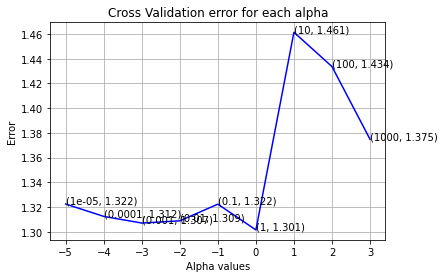

For best alpha value =  1
Train log loss is:  0.8876629695194732
CV log loss is:  1.3014801967958656
Test log loss is:  1.3129678017276685


In [170]:
# onehot encoded 
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
clf = MultinomialNB()
train_model(alpha, clf, train_x_onehot, cv_x_onehot, test_x_onehot, return_value=None)   

Log Loss : 1.3014801967958656
Number of missclassified point : 0.40789473684210525
-------------------- Confusion matrix --------------------


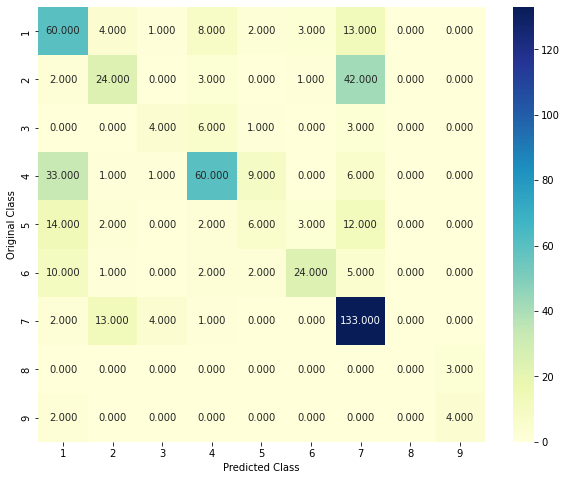

-------------------- Precision matrix (Columm Sum=1) --------------------


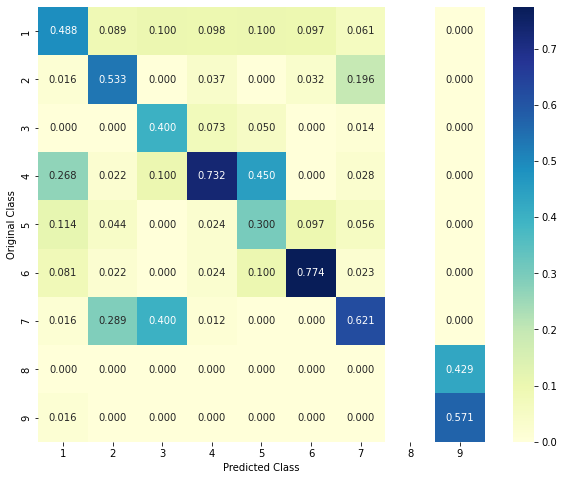

-------------------- Recall matrix (Row sum=1) --------------------


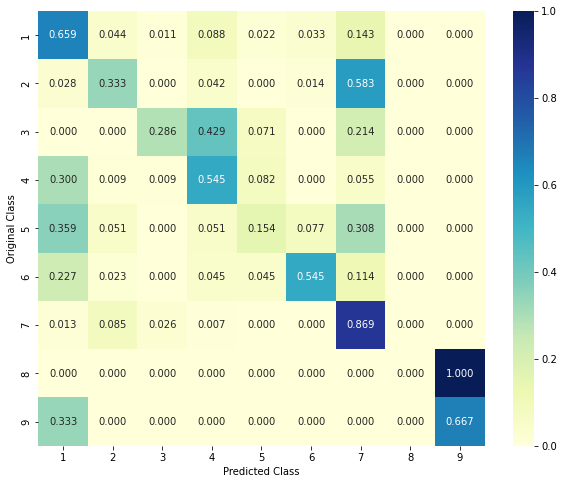

In [172]:
best_alpha = train_model(alpha, clf, train_x_onehot, cv_x_onehot, test_x_onehot, return_value=10)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehot, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehot, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehot)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehot)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehot.toarray()))

In [195]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehot[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehot[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

# feature_log_prob =log(P(x_i|y)) -> empirical log probability of x_i given y_i (number of classes * number of features)
# -1*clf.feature_log_prob_ ->  since they are log prob, log of small values is negative, we convert them into positive values, higher the positive value, higher the probability
# np.argsort() -> index values sorted by probabilties in asc order 
# [:,:no_features] -> gives the top no_features, shape (1, no_of_features)
# [0, :no_features] -> same as above but of size (no_of_features, )
indices=np.argsort(-1*clf.feature_log_prob_)[predicted_cls-1][0,:no_feature]
print("-"*50)
get_imp_feature_names(indices, X_test['Text'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0749 0.3258 0.0238 0.0976 0.0579 0.0399 0.3691 0.0061 0.0048]]
Actual Class : 2
--------------------------------------------------
17 Text feature [presence] present in test data point [True]
18 Text feature [downstream] present in test data point [True]
19 Text feature [recently] present in test data point [True]
20 Text feature [well] present in test data point [True]
21 Text feature [potential] present in test data point [True]
22 Text feature [contrast] present in test data point [True]
24 Text feature [kinase] present in test data point [True]
25 Text feature [activating] present in test data point [True]
26 Text feature [shown] present in test data point [True]
27 Text feature [showed] present in test data point [True]
28 Text feature [however] present in test data point [True]
31 Text feature [previously] present in test data point [True]
32 Text feature [compared] present in test data point [True]
33 Text feature [also] pre

In [236]:
np.argsort(-1*clf.feature_log_prob_)[predicted_cls-1][:,:no_feature][0] #top 100 feature indices of te

array([   54,   740,   107,    23,   150,     5,    82,   324,   114,
          59,    49,   116,   152,   123,   129,   136,   100, 41529,
       19664, 44065, 54412, 41172, 16336, 28722, 30727,  8580, 47382,
       47380, 27293,   101,   183, 41596, 15832,  9480, 25550, 22078,
       14425, 14413, 49220, 28925,  8705, 23454, 22421,  2625, 35712,
       37628, 47559, 51731,  8582, 21165, 37609, 26814, 33676, 29210,
       54610, 48967, 51363, 18527, 28058, 28653, 44611, 23752,  2986,
       44802, 28921, 41901, 16233, 53654, 22864, 36684, 10295, 44064,
       18897, 52235, 16077,  9501, 50957,  4102, 37663, 53123, 47848,
       44607, 49226, 23332,     2,    79,  5593, 16592, 35692, 28930,
       16193, 19165, 50996, 19865, 54606, 20722,  3398, 16074,  8573,
        5599])

In [258]:
X_test['Variation'].iloc[test_point_index]

'Q635E'

In [259]:
X_test['Gene'].iloc[test_point_index]

'SMO'

In [263]:
for i in range(10):
    test_point_index = i
    no_feature = 100
    predicted_cls = sig_clf.predict(test_x_onehot[test_point_index])
    print("Predicted Class :", predicted_cls[0])
    print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehot[test_point_index]),4))
    print("Actual Class :", test_y[test_point_index])
    indices=np.argsort(-1*abs(clf.feature_log_prob_))[predicted_cls-1][0,:no_feature]
    print("-"*50)
    get_imp_feature_names(indices, X_test['Text'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0665 0.0859 0.0211 0.0864 0.0515 0.0353 0.6437 0.0054 0.0042]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0  are present in test data point
Predicted Class : 7
Predicted Class Probabilities: [[0.0749 0.3258 0.0238 0.0976 0.0579 0.0399 0.3691 0.0061 0.0048]]
Actual Class : 2
--------------------------------------------------
Out of the top  100  features  0  are present in test data point
Predicted Class : 4
Predicted Class Probabilities: [[0.1153 0.0836 0.0208 0.6167 0.0504 0.0347 0.0687 0.0053 0.0044]]
Actual Class : 1
--------------------------------------------------
Out of the top  100  features  0  are present in test data point
Predicted Class : 2
Predicted Class Probabilities: [[0.0764 0.4704 0.0244 0.0992 0.0591 0.0405 0.219  0.0062 0.0048]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0  are present in test data po

### K Nearest Neighbors


for alpha = 5
Log Loss : 1.149846638363323
for alpha = 11
Log Loss : 1.1519486945570063
for alpha = 15
Log Loss : 1.1440629510531422
for alpha = 21
Log Loss : 1.1510814764543391
for alpha = 31
Log Loss : 1.1435216023323498
for alpha = 41
Log Loss : 1.1367257548569565
for alpha = 51
Log Loss : 1.1233181959349192
for alpha = 99
Log Loss : 1.1192124430305532


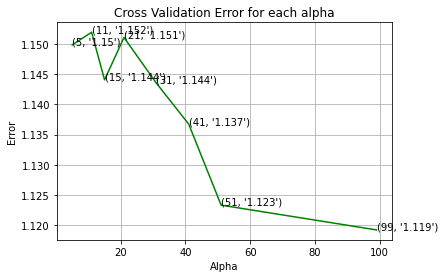

For values of best alpha =  99 The train log loss is: 0.9216420740536245
For values of best alpha =  99 The cross validation log loss is: 1.1192124430305532
For values of best alpha =  99 The test log loss is: 1.1397803492365723


In [271]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_rc, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_rc, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_rc)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_rc, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_rc, train_y)

predict_y = sig_clf.predict_proba(train_x_rc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_rc)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_rc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))


Log loss:  1.1192124430305532
Numbero of misclassified points:  0.40977443609022557
-------------------- Confusion matrix --------------------


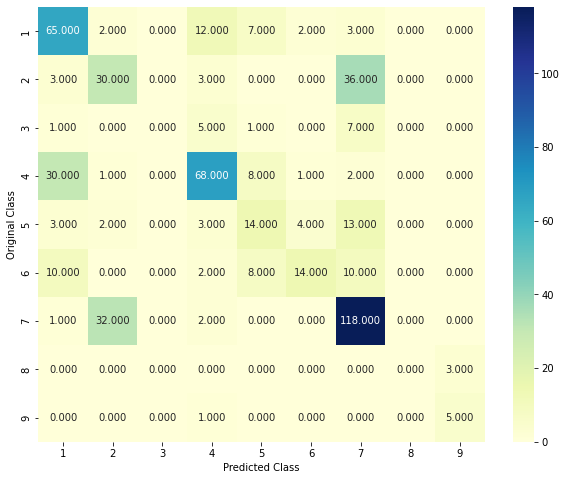

-------------------- Precision matrix (Columm Sum=1) --------------------


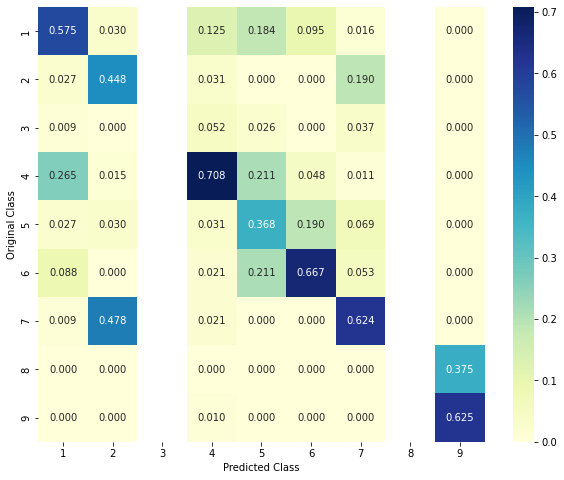

-------------------- Recall matrix (Row sum=1) --------------------


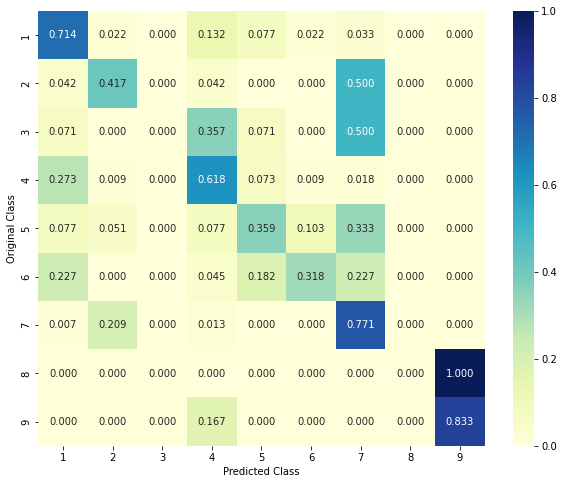

In [278]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_plot_confusion_matrix(train_x_rc, train_y, cv_x_rc, cv_y, clf)

In [279]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_rc, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_rc, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_rc[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_rc[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 2
The  99  nearest neighbours of the test points belongs to classes [7 7 2 2 2 7 7 7 2 2 7 2 2 2 2 7 7 7 7 7 7 7 7 2 7 2 7 7 2 7 7 7 2 7 2 2 7
 5 6 7 7 7 2 7 7 7 2 7 7 2 2 2 2 2 2 2 2 2 2 2 2 2 7 2 2 5 7 7 2 7 2 7 7 7
 5 5 7 7 2 2 7 2 7 7 7 7 2 2 7 7 7 7 7 7 2 5 6 7 2]
Fequency of nearest points : Counter({7: 51, 2: 41, 5: 5, 6: 2})


In [287]:
clf.kneighbors(test_x_rc[test_point_index].reshape(1,-1))

(array([[0.01093308, 0.01093308, 0.01104346, 0.01104346, 0.01104346,
         0.01265266, 0.01265266, 0.01399916, 0.02383124, 0.02383124,
         0.03210756, 0.04187921, 0.04465173, 0.04479208, 0.04648588,
         0.05331936, 0.05331936, 0.05331936, 0.05331936, 0.05331936,
         0.05331936, 0.05331936, 0.05331936, 0.0533585 , 0.0533585 ,
         0.0533585 , 0.0535823 , 0.05365153, 0.054215  , 0.05435568,
         0.05435568, 0.05437318, 0.05483392, 0.05515835, 0.05525997,
         0.05525997, 0.05553012, 0.05559674, 0.05559674, 0.0567359 ,
         0.0570671 , 0.05717867, 0.05727724, 0.05827793, 0.05829505,
         0.05885055, 0.05904726, 0.05911212, 0.05923397, 0.05967267,
         0.06021717, 0.06063495, 0.06063495, 0.06063495, 0.06094702,
         0.06094702, 0.06094702, 0.06094702, 0.06094702, 0.06094702,
         0.06162306, 0.06278201, 0.06377946, 0.06392925, 0.06398063,
         0.06526731, 0.06558927, 0.06590368, 0.06592263, 0.06623614,
         0.06663245, 0.06672291, 0

In [293]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_rc, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_rc, train_y)

test_point_index = 3
predicted_cls = sig_clf.predict(test_x_rc[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_rc[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  99  nearest neighbours of the test points belongs to classes [2 7 2 7 2 6 7 7 2 2 7 5 2 2 2 5 7 7 2 2 7 7 2 2 2 7 7 7 7 7 7 5 5 2 7 2 7
 5 2 7 7 7 7 2 7 2 7 2 5 3 7 7 7 7 7 7 2 6 2 2 7 7 7 7 4 7 7 2 2 2 2 7 7 7
 7 7 7 6 7 7 5 2 2 5 2 7 6 7 7 2 7 2 2 7 2 7 7 2 7]
Fequency of nearest points : Counter({7: 51, 2: 34, 5: 8, 6: 4, 3: 1, 4: 1})


### Logistic Regression

- With Class balancing

For alpha =  1e-06 , log loss is:  1.3209866080036894
For alpha =  1e-05 , log loss is:  1.289944283885878
For alpha =  0.0001 , log loss is:  1.1517056850400818
For alpha =  0.001 , log loss is:  1.1401784529868966
For alpha =  0.01 , log loss is:  1.1965163039020754
For alpha =  0.1 , log loss is:  1.482643901115452
For alpha =  1 , log loss is:  1.7045298627894714
For alpha =  10 , log loss is:  1.7334947569714605
For alpha =  100 , log loss is:  1.736509797035141


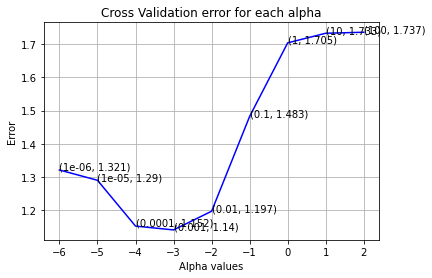

For best alpha value =  0.001
Train log loss is:  0.5097634431914013
CV log loss is:  1.1401784529868966
Test log loss is:  1.0543098043960435


In [334]:
alpha = [10**x for x in range(-6,3)]
clf = SGDClassifier(class_weight='balanced',penalty='l2', loss='log_loss', random_state=42)
train_model(alpha,clf,train_x_onehot, cv_x_onehot, test_x_onehot, return_value=None)


Log loss:  1.1401784529868966
Numbero of misclassified points:  0.37781954887218044
-------------------- Confusion matrix --------------------


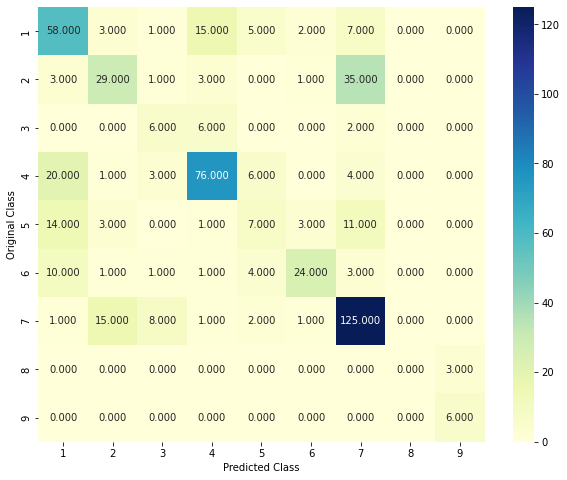

-------------------- Precision matrix (Columm Sum=1) --------------------


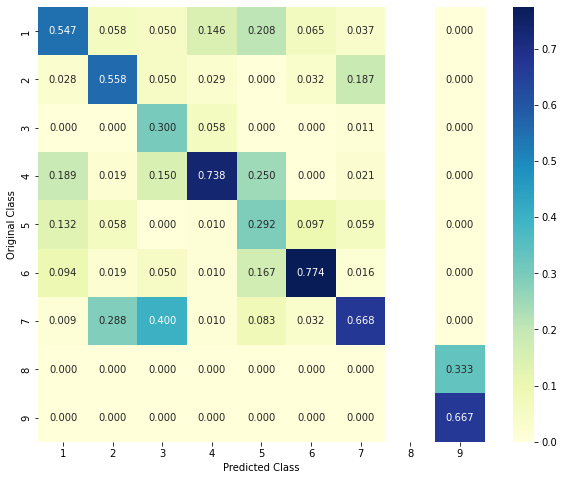

-------------------- Recall matrix (Row sum=1) --------------------


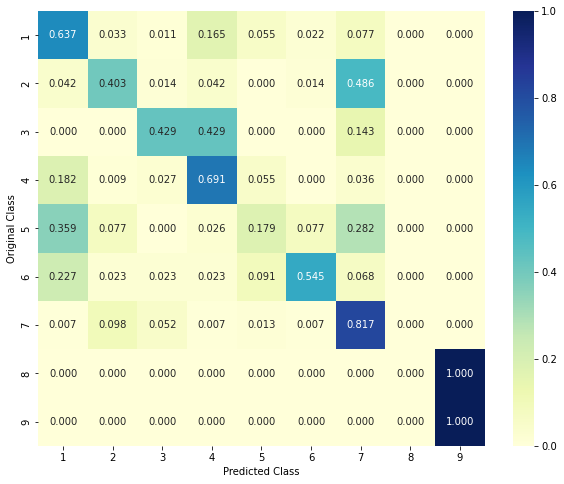

In [317]:
best_alpha = train_model(alpha,clf,train_x_onehot, cv_x_onehot, test_x_onehot, return_value=10)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehot, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehot, train_y)

predict_plot_confusion_matrix(train_x_onehot,train_y, cv_x_onehot,cv_y, clf)

In [312]:
# get important features

def get_imp_features(text, indices, removed_ind = []):
    word_present = 0
    feature_table = []
    asc_order_index = 0
    for i in indices:
        if i < train_gene_onehot.shape[1]:
            feature_table.append([asc_order_index, "Gene", "True"])
        elif i<18:
            feature_table.append([asc_order_index, "Variation", "True"])
        if ((i>17) & (i not in removed_ind)):
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present+=1
            feature_table.append(asc_order_index, train_text_features[i], yes_no)
        asc_order_index+=1
    print(word_present, " most impfeatures are present in the test point")
    print("-"*50)
    print("Important features for predicted class ",predicted_cls[0]," : ")
    print(tabulate(feature_table, headers=["Index","Feature name", "Present/Not"]))
              

In [320]:
test_point_index = 1
no_feature = 500
clf= SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehot, train_y)
predicted_cls = sig_clf.predict(test_x_onehot[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehot[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

# clf.coef_ -> coefficient of features (number of classes, number of features)
# -1*clf.coef- -> to sort with highest weights/coeff first
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][0,:no_feature]
print("-"*50)
get_imp_feature_names(indices, X_test['Text'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0261 0.7804 0.0037 0.0121 0.0178 0.0147 0.1365 0.0047 0.004 ]]
Actual Class : 2
--------------------------------------------------
158 Text feature [heptahelical] present in test data point [True]
277 Text feature [d473h] present in test data point [True]
439 Text feature [uncontrolled] present in test data point [True]
Out of the top  500  features  3  are present in test data point


In [325]:
clf.coef_

array([[-4.54463815e-01,  1.80814806e-01, -2.28202355e-01, ...,
         6.13993817e-03, -2.14920805e-02, -1.29401116e-02],
       [ 1.18843173e+00, -6.30576344e-02,  6.36763769e-02, ...,
         9.47474997e-02,  5.41736087e-02,  5.20584331e-02],
       [-3.50564469e-01, -4.56359425e-02,  5.40963825e-02, ...,
        -3.61980755e-04, -6.04550620e-03, -3.07355328e-03],
       ...,
       [-5.73313444e-01, -7.31405594e-02, -5.91346909e-03, ...,
        -2.32840496e-02, -4.41074688e-03, -7.26770483e-03],
       [-3.00722395e-01, -5.91081241e-02,  7.44708372e-01, ...,
        -1.07253726e-04, -4.98020884e-03, -1.82572208e-02],
       [-2.00690946e-01, -2.77270329e-02, -3.79482186e-01, ...,
        -2.35507023e-04, -4.61383353e-03,  4.90254528e-02]])

In [330]:
test_point_index= 26
no_feature = 500
clf.fit(train_x_onehot, train_y)
predicted_cls = sig_clf.predict(test_x_onehot[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehot[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

# clf.coef_ -> coefficient of features (number of classes, number of features)
# -1*clf.coef- -> to sort with highest weights/coeff first
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][0,:no_feature]
print("-"*50)
get_imp_feature_names(indices, X_test['Text'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.0288 0.0346 0.0058 0.3279 0.5491 0.0145 0.0274 0.0061 0.0057]]
Actual Class : 4
--------------------------------------------------
175 Text feature [512] present in test data point [True]
188 Text feature [pyrimidines] present in test data point [True]
374 Text feature [g230x] present in test data point [True]
375 Text feature [q110r] present in test data point [True]
376 Text feature [pyrimidone] present in test data point [True]
377 Text feature [dipyrimidines] present in test data point [True]
378 Text feature [ezviewtm] present in test data point [True]
379 Text feature [292c] present in test data point [True]
380 Text feature [cycloadenines] present in test data point [True]
381 Text feature [p95s] present in test data point [True]
382 Text feature [s362l] present in test data point [True]
383 Text feature [capsure] present in test data point [True]
384 Text feature [d301n] present in test data point [True]
385 Text feature [e

- Without class balancing

For alpha =  1e-06 , log loss is:  1.3030130794894614
For alpha =  1e-05 , log loss is:  1.272114657898183
For alpha =  0.0001 , log loss is:  1.1813521281564265
For alpha =  0.001 , log loss is:  1.1520958137263833
For alpha =  0.01 , log loss is:  1.2420667612746112
For alpha =  0.1 , log loss is:  1.4122075507042187
For alpha =  1 , log loss is:  1.6268397562587333


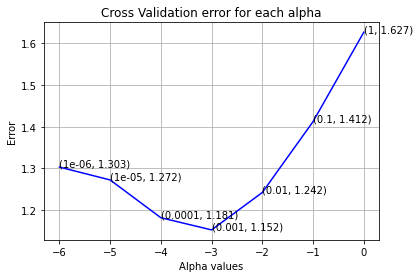

For best alpha value =  0.001
Train log loss is:  0.5039519019258055
CV log loss is:  1.1520958137263833
Test log loss is:  1.0568621567504841


In [336]:
alpha = [10**x for x in range(-6,1)]
# only the class_weight='balanced' parameter is not given
clf = SGDClassifier(penalty='l2', loss='log_loss', random_state=42)
train_model(alpha,clf,train_x_onehot, cv_x_onehot, test_x_onehot, return_value=None)


Log loss:  1.1520958137263833
Numbero of misclassified points:  0.37781954887218044
-------------------- Confusion matrix --------------------


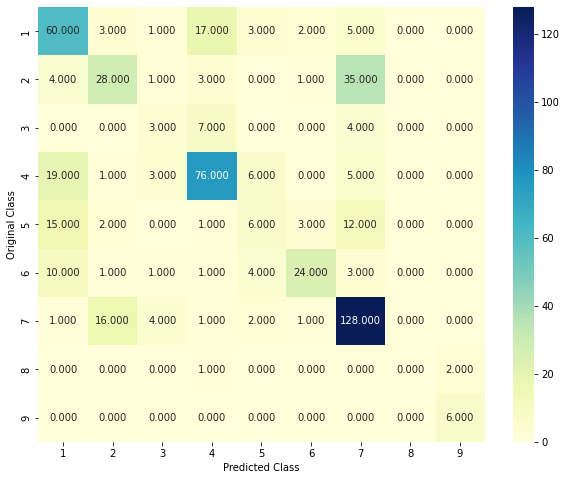

-------------------- Precision matrix (Columm Sum=1) --------------------


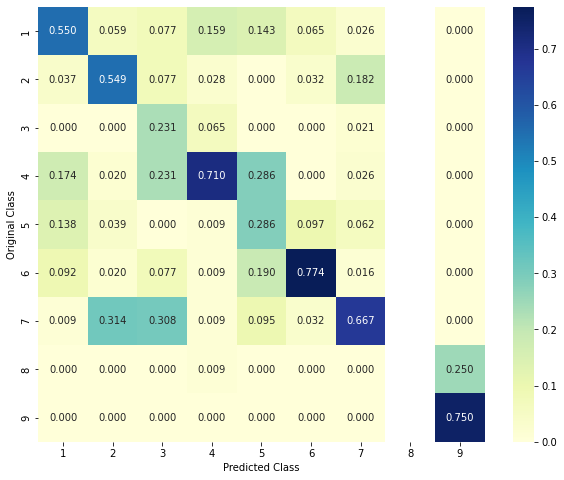

-------------------- Recall matrix (Row sum=1) --------------------


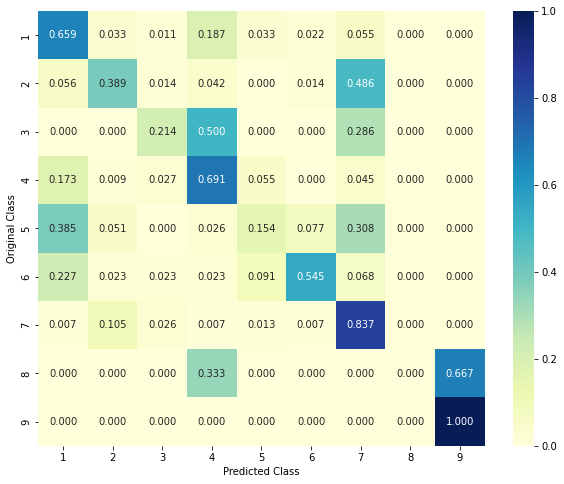

In [332]:
best_alpha = train_model(alpha,clf,train_x_onehot, cv_x_onehot, test_x_onehot, return_value=10)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehot, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehot, train_y)

predict_plot_confusion_matrix(train_x_onehot,train_y, cv_x_onehot,cv_y, clf)

In [337]:
test_point_index = 1
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehot[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehot[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

# clf.coef_ -> coefficient of features (number of classes, number of features)
# -1*clf.coef- -> to sort with highest weights/coeff first
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][0,:no_feature]
print("-"*50)
get_imp_feature_names(indices, X_test['Text'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0273 0.8032 0.0034 0.0132 0.0184 0.0149 0.1129 0.0041 0.0026]]
Actual Class : 2
--------------------------------------------------
149 Text feature [heptahelical] present in test data point [True]
237 Text feature [d473h] present in test data point [True]
451 Text feature [uncontrolled] present in test data point [True]
456 Text feature [tm6] present in test data point [True]
Out of the top  500  features  4  are present in test data point


In [338]:
test_point_index = 30
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehot[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehot[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

# clf.coef_ -> coefficient of features (number of classes, number of features)
# -1*clf.coef- -> to sort with highest weights/coeff first
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][0,:no_feature]
print("-"*50)
get_imp_feature_names(indices, X_test['Text'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.4936 0.0942 0.0014 0.0146 0.0097 0.0064 0.3737 0.0051 0.0014]]
Actual Class : 9
--------------------------------------------------
153 Text feature [ddit3] present in test data point [True]
340 Text feature [primitive] present in test data point [True]
355 Text feature [stains] present in test data point [True]
405 Text feature [posterior] present in test data point [True]
446 Text feature [poly] present in test data point [True]
Out of the top  500  features  5  are present in test data point


### Linear Support Vector Machines

For alpha =  1e-05 , log loss is:  1.2965492829583403
For alpha =  0.0001 , log loss is:  1.2452637818041055
For alpha =  0.001 , log loss is:  1.1689569556961061
For alpha =  0.01 , log loss is:  1.1863310957819337
For alpha =  0.1 , log loss is:  1.4270502801737828
For alpha =  1 , log loss is:  1.7274319205928461
For alpha =  10 , log loss is:  1.7370756696301075
For alpha =  100 , log loss is:  1.7370756551605722


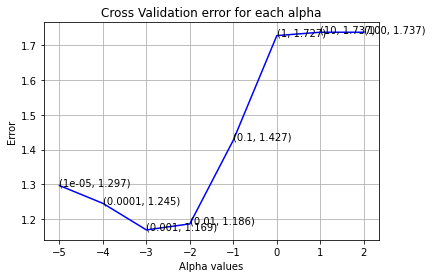

For best alpha value =  0.001
Train log loss is:  0.5120071724476607
CV log loss is:  1.1689569556961061
Test log loss is:  1.1179756960702247


In [339]:
alpha = [10**x for x in range(-5,3)]
clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
train_model(alpha, clf, train_x_onehot, cv_x_onehot, test_x_onehot, return_value=None)

Log loss:  1.1769098505094746
Numbero of misclassified points:  0.37218045112781956
-------------------- Confusion matrix --------------------


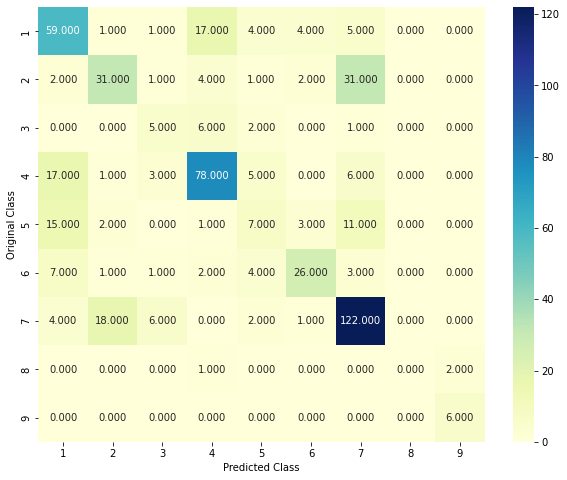

-------------------- Precision matrix (Columm Sum=1) --------------------


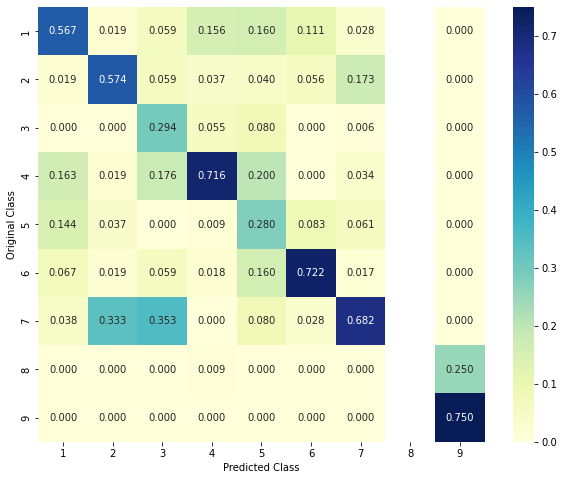

-------------------- Recall matrix (Row sum=1) --------------------


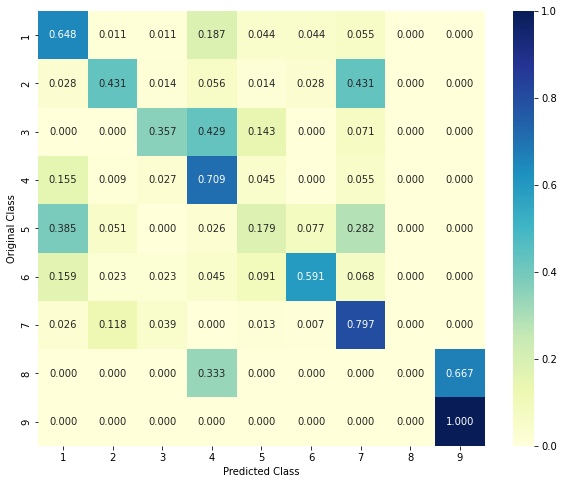

In [340]:
best_alpha = train_model(alpha,clf,train_x_onehot, cv_x_onehot, test_x_onehot, return_value=10)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehot, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehot, train_y)

predict_plot_confusion_matrix(train_x_onehot,train_y, cv_x_onehot,cv_y, clf)

In [345]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehot[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehot[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_imp_feature_names(indices[0], X_test['Text'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0541 0.7737 0.01   0.0428 0.0369 0.0189 0.0549 0.0045 0.0041]]
Actual Class : 2
--------------------------------------------------
152 Text feature [heptahelical] present in test data point [True]
155 Text feature [d473h] present in test data point [True]
282 Text feature [tm6] present in test data point [True]
Out of the top  500  features  3  are present in test data point


In [367]:
test_point_index = 30
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehot[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehot[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_imp_feature_names(indices[0], X_test['Text'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.4796 0.0741 0.0065 0.0487 0.0334 0.0203 0.3286 0.0046 0.0043]]
Actual Class : 9
--------------------------------------------------
485 Text feature [primitive] present in test data point [True]
496 Text feature [permissive] present in test data point [True]
Out of the top  500  features  2  are present in test data point


### Random Forest Classifier

- With OneHot encoding

In [372]:
alpha = [100,200,500,1000,2000]

max_depth = [5,10]
cv_log_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehot, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehot, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehot)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

# fig, ax = plt.subplots()
# features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
# ax.plot(features, cv_log_error_array,c='g')
# for i, txt in enumerate(np.round(cv_log_error_array,3)):
#     ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
# plt.grid()
# plt.title("Cross Validation Error for each alpha")
# plt.xlabel("Alpha i's")
# plt.ylabel("Error measure")
# plt.show()
        
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehot, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehot, train_y)


for n_estimators = 100 and max depth =  5
Log Loss : 1.2778191868332602
for n_estimators = 100 and max depth =  10
Log Loss : 1.2097902047556002
for n_estimators = 200 and max depth =  5
Log Loss : 1.2667797055422962
for n_estimators = 200 and max depth =  10
Log Loss : 1.2070023755107797
for n_estimators = 500 and max depth =  5
Log Loss : 1.2643810623797889
for n_estimators = 500 and max depth =  10
Log Loss : 1.199520163668217
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2681477048187388
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1976376778292124
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2629347257192913
for n_estimators = 2000 and max depth =  10
Log Loss : 1.19584917120619


CalibratedClassifierCV(estimator=RandomForestClassifier(max_depth=10,
                                                        n_estimators=200,
                                                        n_jobs=-1,
                                                        random_state=42))

In [375]:
predict_y = sig_clf.predict_proba(train_x_onehot)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehot)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehot)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best estimator =  200 The train log loss is: 0.680253345684606
For values of best estimator =  200 The cross validation log loss is: 1.2070023755107795
For values of best estimator =  200 The test log loss is: 1.1857765741087791


Log loss:  1.2070023755107797
Numbero of misclassified points:  0.43045112781954886
-------------------- Confusion matrix --------------------


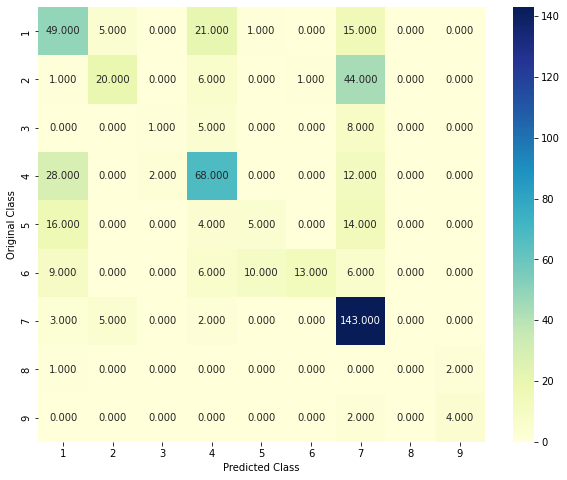

-------------------- Precision matrix (Columm Sum=1) --------------------


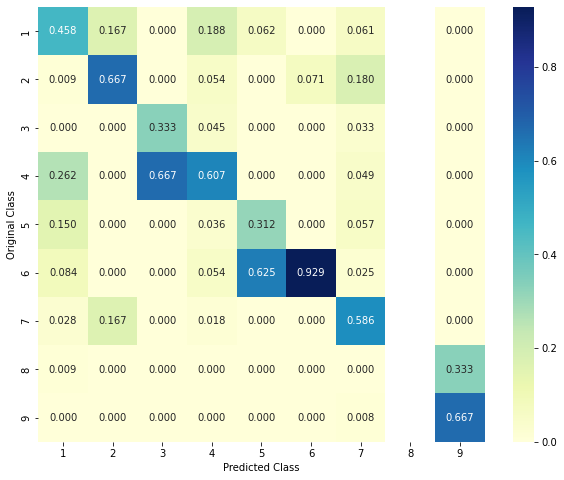

-------------------- Recall matrix (Row sum=1) --------------------


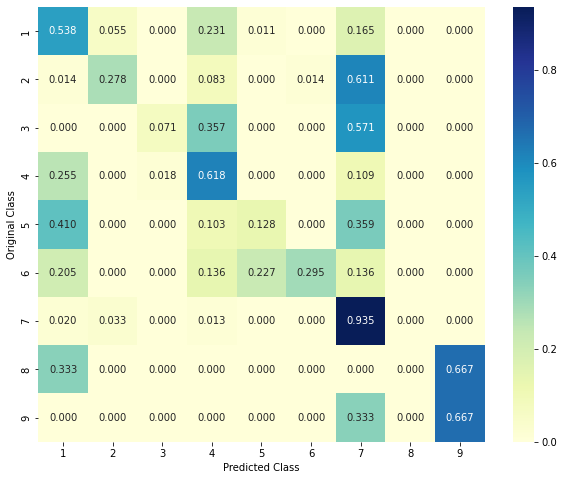

In [376]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)],criterion='gini',max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehot, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehot, train_y)
predict_plot_confusion_matrix(train_x_onehot, train_y, cv_x_onehot,cv_y, clf)

In [378]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehot[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehot[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_imp_feature_names(indices[:no_feature], X_test['Text'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0726 0.2928 0.0188 0.0484 0.0426 0.0369 0.4744 0.0059 0.0076]]
Actual Class : 2
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [therapeutic] present in test data point [True]
3 Text feature [activation] present in test data point [True]
4 Text feature [constitutive] present in test data point [True]
8 Text feature [inhibitor] present in test data point [True]
11 Text feature [oncogenic] present in test data point [True]
12 Text feature [cells] present in test data point [True]
13 Text feature [missense] present in test data point [True]
14 Text feature [inhibitors] present in test data point [True]
18 Text feature [cell] present in test data point [True]
23 Text feature [function] present in test data point [True]
24 Text feature [signaling] present in test data point [True]
25 Text feature [pat

316 Text feature [conserved] present in test data point [True]
318 Text feature [different] present in test data point [True]
320 Text feature [also] present in test data point [True]
325 Text feature [binding] present in test data point [True]
326 Text feature [total] present in test data point [True]
328 Text feature [mutations] present in test data point [True]
329 Text feature [functions] present in test data point [True]
330 Text feature [target] present in test data point [True]
331 Text feature [rate] present in test data point [True]
333 Text feature [associated] present in test data point [True]
334 Text feature [biopsies] present in test data point [True]
335 Text feature [concentration] present in test data point [True]
336 Text feature [based] present in test data point [True]
338 Text feature [described] present in test data point [True]
341 Text feature [genetic] present in test data point [True]
342 Text feature [basis] present in test data point [True]
343 Text feature 

In [380]:
test_point_index = 300
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehot[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehot[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_imp_feature_names(indices[:no_feature], X_test['Text'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5113 0.044  0.0203 0.1674 0.0584 0.0989 0.0837 0.0067 0.0093]]
Actual Class : 1
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
6 Text feature [suppressor] present in test data point [True]
8 Text feature [inhibitor] present in test data point [True]
9 Text feature [akt] present in test data point [True]
12 Text feature [cells] present in test data point [True]
13 Text feature [missense] present in test data point [True]
18 Text feature [cell] present in test data point [True]
19 Text feature [phosphorylation] present in test data point [True]
23 Text feature [function] present in test data point [True]
30 Text feature [functional] present in test data point [True]
34 Text feature [trials] present in test data point [True]
35 Text feature [phosphatase] present in test data point [True]
40 Text feature [enhanced] present in test data point [True]
46 Text feature [loss] pre

387 Text feature [made] present in test data point [True]
390 Text feature [14] present in test data point [True]
393 Text feature [number] present in test data point [True]
394 Text feature [specific] present in test data point [True]
395 Text feature [determine] present in test data point [True]
398 Text feature [demonstrated] present in test data point [True]
399 Text feature [could] present in test data point [True]
402 Text feature [possible] present in test data point [True]
406 Text feature [endogenous] present in test data point [True]
407 Text feature [low] present in test data point [True]
408 Text feature [state] present in test data point [True]
409 Text feature [incubated] present in test data point [True]
410 Text feature [despite] present in test data point [True]
411 Text feature [22] present in test data point [True]
418 Text feature [catalytic] present in test data point [True]
419 Text feature [table] present in test data point [True]
420 Text feature [progression] p

- With Response Encoding

In [381]:
alpha = [10,50,100,200,500,1000,2000]

max_depth = [2,3,5,10]
cv_log_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_rc, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_rc, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_rc)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

# fig, ax = plt.subplots()
# features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
# ax.plot(features, cv_log_error_array,c='g')
# for i, txt in enumerate(np.round(cv_log_error_array,3)):
#     ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
# plt.grid()
# plt.title("Cross Validation Error for each alpha")
# plt.xlabel("Alpha i's")
# plt.ylabel("Error measure")
# plt.show()
        
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_rc, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_rc, train_y)


for n_estimators = 10 and max depth =  2
Log Loss : 1.9723996914911746
for n_estimators = 10 and max depth =  3
Log Loss : 1.6307475387914074
for n_estimators = 10 and max depth =  5
Log Loss : 1.4545270031742876
for n_estimators = 10 and max depth =  10
Log Loss : 1.8012108610859583
for n_estimators = 50 and max depth =  2
Log Loss : 1.6229380870772245
for n_estimators = 50 and max depth =  3
Log Loss : 1.3861834247388962
for n_estimators = 50 and max depth =  5
Log Loss : 1.414598201691991
for n_estimators = 50 and max depth =  10
Log Loss : 1.7511352042018518
for n_estimators = 100 and max depth =  2
Log Loss : 1.540264519827272
for n_estimators = 100 and max depth =  3
Log Loss : 1.4395253691007184
for n_estimators = 100 and max depth =  5
Log Loss : 1.412018804785485
for n_estimators = 100 and max depth =  10
Log Loss : 1.6995780276812193
for n_estimators = 200 and max depth =  2
Log Loss : 1.543763840427665
for n_estimators = 200 and max depth =  3
Log Loss : 1.405334339444949
fo

CalibratedClassifierCV(estimator=RandomForestClassifier(max_depth=3,
                                                        n_estimators=50,
                                                        n_jobs=-1,
                                                        random_state=42))

In [382]:
predict_y = sig_clf.predict_proba(train_x_rc)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(train_y, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_rc)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(cv_y, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_rc)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best estimator =  50 The train log loss is: 0.15406126593638111
For values of best estimator =  50 The cross validation log loss is: 1.386183424738896
For values of best estimator =  50 The test log loss is: 1.4328374879446664


Log loss:  1.8012108610859583
Numbero of misclassified points:  0.7255639097744361
-------------------- Confusion matrix --------------------


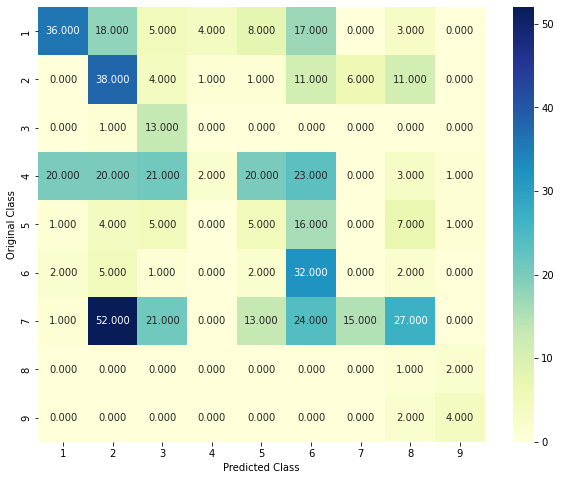

-------------------- Precision matrix (Columm Sum=1) --------------------


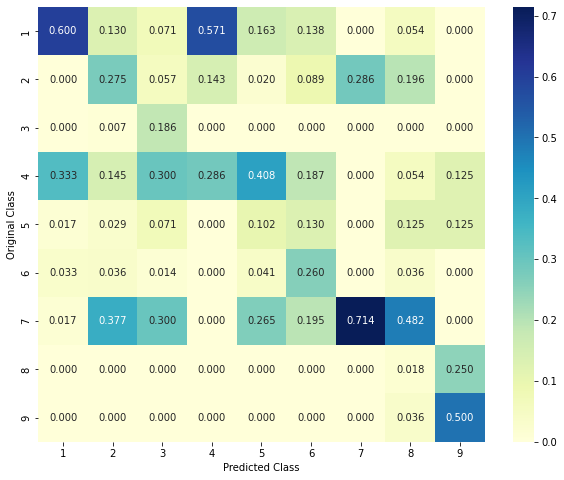

-------------------- Recall matrix (Row sum=1) --------------------


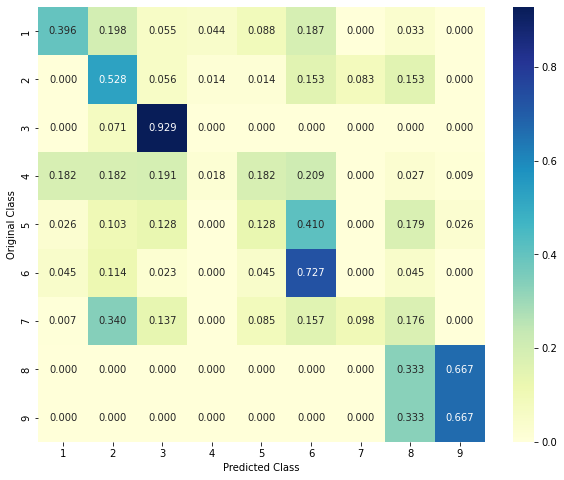

In [383]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)],criterion='gini',max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_rc, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_rc, train_y)
predict_plot_confusion_matrix(train_x_rc, train_y, cv_x_rc,cv_y, clf)

In [391]:
test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_rc[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_rc[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
# get_imp_feature_names(indices[:no_feature], X_test['Text'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0416 0.2314 0.0994 0.0345 0.1412 0.1668 0.2056 0.0675 0.0121]]
Actual Class : 2
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature


In [392]:
test_point_index = 30
no_feature = 27
predicted_cls = sig_clf.predict(test_x_rc[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_rc[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
# get_imp_feature_names(indices[:no_feature], X_test['Text'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 8
Predicted Class Probabilities: [[0.166  0.2248 0.0272 0.0724 0.0864 0.1062 0.0278 0.2355 0.0537]]
Actual Class : 9
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Gene is important feature


### Stack the models

In [520]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log_loss', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehot, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehot, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=1)
clf3.fit(train_x_onehot, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehot, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehot))))
sig_clf2.fit(train_x_onehot, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehot))))
sig_clf3.fit(train_x_onehot, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehot))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehot, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehot))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehot))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.15
Support vector machines : Log Loss: 1.17
Naive Bayes : Log Loss: 1.30
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.811
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.669
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.263
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.225
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.537
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 2.000


Log loss (train) on the stacking classifier : 0.36657074769048864
Log loss (CV) on the stacking classifier : 1.224559836468707
Log loss (test) on the stacking classifier : 1.18849335295433
Number of missclassified point : 0.3669172932330827
-------------------- Confusion matrix --------------------


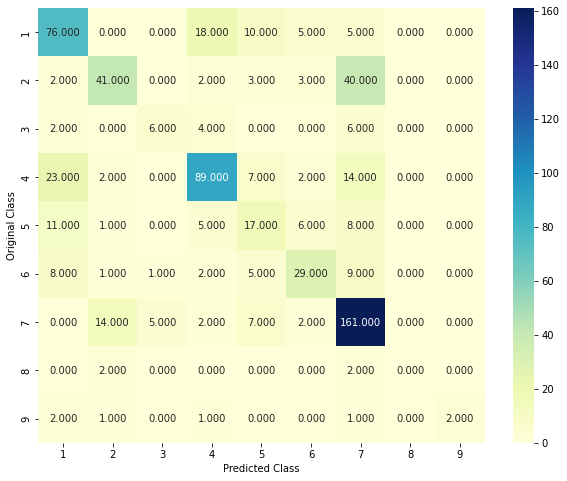

-------------------- Precision matrix (Columm Sum=1) --------------------


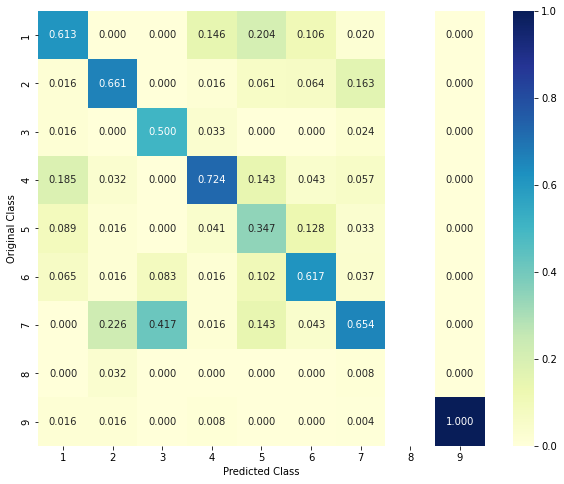

-------------------- Recall matrix (Row sum=1) --------------------


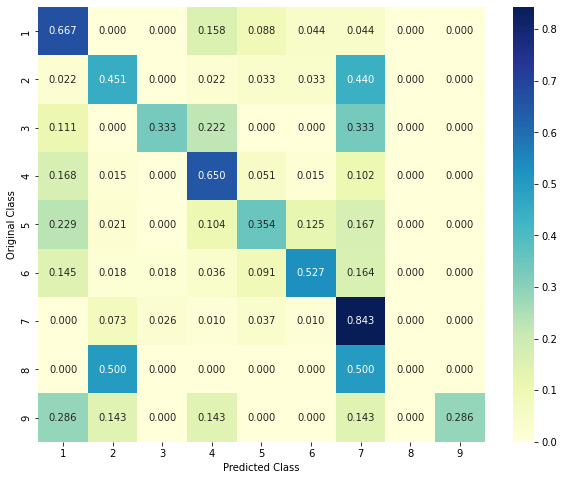

In [521]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehot, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehot))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehot))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehot))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehot)- test_y))/test_y.shape[0])
plot_confusion_matrix(y_test, sclf.predict(test_x_onehot))

### Maximum Voting Classifier

Log loss (train) on the VotingClassifier : 0.5855994260326626
Log loss (CV) on the VotingClassifier : 1.0926079198271024
Log loss (test) on the VotingClassifier : 1.0768217741066168
Number of missclassified point : 0.3609022556390977
-------------------- Confusion matrix --------------------


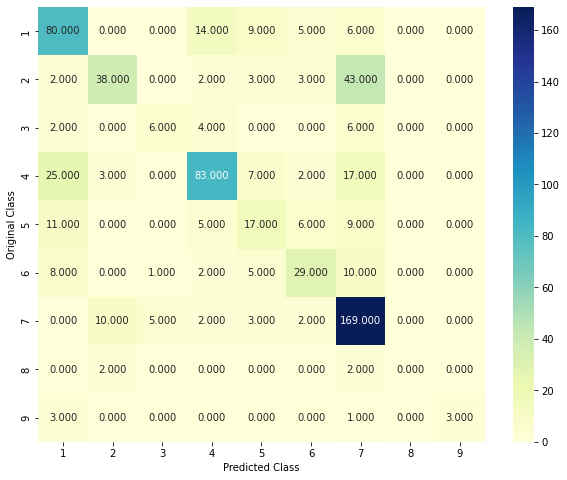

-------------------- Precision matrix (Columm Sum=1) --------------------


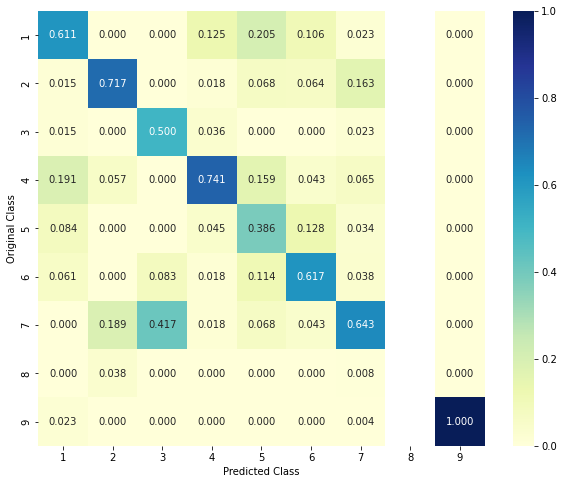

-------------------- Recall matrix (Row sum=1) --------------------


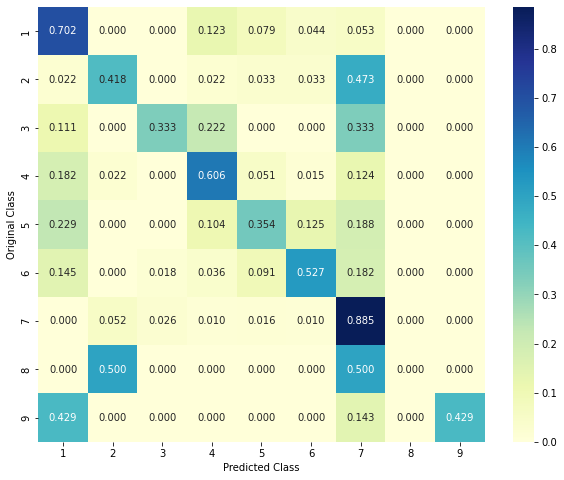

In [522]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehot, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehot)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehot)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehot)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehot)- test_y))/test_y.shape[0])
plot_confusion_matrix(y_test, vclf.predict(test_x_onehot))

### TF-IDF Vectorizer

In [502]:
## Gene Feature

tfidf_gene = TfidfVectorizer()
train_gene_tfidf = tfidf_gene.fit_transform(train_df['Gene'])
tfidf_gene_features = tfidf_gene.get_feature_names_out()
tfidf_gene_count = train_gene_tfidf.sum(axis=0).A1
tfidf_gene_dict = dict(zip(list(tfidf_gene_features), tfidf_gene_count))
tfidf_gene_dict

{'abl1': 19.0,
 'ago2': 2.0,
 'akt1': 15.0,
 'akt2': 9.0,
 'akt3': 2.0,
 'alk': 39.0,
 'apc': 4.0,
 'ar': 13.0,
 'araf': 5.0,
 'arid1b': 1.0,
 'arid2': 1.0,
 'asxl1': 1.0,
 'asxl2': 1.0,
 'atm': 4.0,
 'atr': 1.0,
 'atrx': 1.0,
 'aurka': 3.0,
 'aurkb': 1.0,
 'axl': 1.0,
 'b2m': 3.0,
 'bap1': 6.0,
 'bcl10': 2.0,
 'bcor': 2.0,
 'braf': 59.0,
 'brca1': 170.0,
 'brca2': 79.0,
 'brd4': 1.0,
 'brip1': 6.0,
 'btk': 3.0,
 'card11': 7.0,
 'carm1': 2.0,
 'casp8': 4.0,
 'cbl': 16.0,
 'ccnd1': 9.0,
 'ccnd3': 5.0,
 'cdh1': 7.0,
 'cdk12': 6.0,
 'cdk6': 2.0,
 'cdk8': 1.0,
 'cdkn1a': 2.0,
 'cdkn1b': 1.0,
 'cdkn2a': 34.0,
 'cdkn2b': 5.0,
 'cebpa': 1.0,
 'chek2': 5.0,
 'cic': 3.0,
 'crebbp': 6.0,
 'ctcf': 3.0,
 'ctla4': 1.0,
 'ctnnb1': 20.0,
 'ddr2': 6.0,
 'dicer1': 4.0,
 'dnmt3a': 2.0,
 'dnmt3b': 2.0,
 'egfr': 95.0,
 'elf3': 5.0,
 'ep300': 7.0,
 'epas1': 3.0,
 'epcam': 1.0,
 'erbb2': 42.0,
 'erbb3': 6.0,
 'erbb4': 10.0,
 'ercc2': 13.0,
 'ercc3': 1.0,
 'ercc4': 4.0,
 'erg': 4.0,
 'esr1': 11.0,
 'etv1': 1

In [503]:
len(tfidf_gene_dict)

229

In [504]:

# gene feature
train_gene_tfidf = normalize(train_gene_tfidf, axis=0)

cv_gene_tfidf = tfidf_gene.transform(cv_df['Gene'])
cv_gene_tfidf = normalize(cv_gene_tfidf, axis=0)

test_gene_tfidf = tfidf_gene.transform(X_test['Gene'])
test_gene_tfidf = normalize(test_gene_tfidf, axis=0)



In [505]:
## Variation Feature

tfidf_var = TfidfVectorizer()
train_var_tfidf = tfidf_var.fit_transform(train_df['Variation'])
tfidf_var_features = tfidf_var.get_feature_names_out()
tfidf_var_count = train_var_tfidf.sum(axis=0).A1
tfidf_var_dict = dict(zip(list(tfidf_var_features), tfidf_var_count))
tfidf_var_dict

{'126': 0.7071067811865476,
 '13': 0.6801885080986124,
 '17': 0.7071067811865476,
 '19': 0.5624166008985838,
 '256_286trunc': 1.0,
 '385_418del': 1.0,
 '422_605trunc': 1.0,
 '51': 0.7071067811865476,
 '550_592del': 1.0,
 '596_619splice': 1.0,
 '6a': 0.7071067811865476,
 '981_1028splice': 1.0,
 'a1020v': 1.0,
 'a1022e': 1.0,
 'a1099t': 1.0,
 'a111p': 1.0,
 'a1131t': 1.0,
 'a1170v': 1.0,
 'a120s': 1.0,
 'a121e': 1.0,
 'a1234t': 1.0,
 'a126d': 1.0,
 'a126s': 1.0,
 'a126v': 1.0,
 'a1459p': 1.0,
 'a146t': 1.0,
 'a146v': 2.0,
 'a148t': 1.0,
 'a1519t': 1.0,
 'a151t': 1.0,
 'a161s': 1.0,
 'a1685s': 1.0,
 'a1701p': 1.0,
 'a1708e': 1.0,
 'a1708v': 1.0,
 'a171v': 1.0,
 'a1752v': 1.0,
 'a1789t': 1.0,
 'a1843t': 1.0,
 'a18d': 1.0,
 'a197t': 1.0,
 'a19v': 1.0,
 'a2034v': 1.0,
 'a209t': 1.0,
 'a2351g': 1.0,
 'a23e': 1.0,
 'a2425t': 1.0,
 'a246p': 1.0,
 'a263v': 1.0,
 'a2717s': 1.0,
 'a2770t': 1.0,
 'a290t': 1.0,
 'a298t': 1.0,
 'a339v': 1.0,
 'a347t': 1.0,
 'a349p': 1.0,
 'a34d': 1.0,
 'a36p': 1.0,
 

In [506]:
len(tfidf_var_dict)

1959

In [507]:
# var feature
train_var_tfidf = normalize(train_var_tfidf, axis=0)

cv_var_tfidf = tfidf_var.transform(cv_df['Variation'])
cv_var_tfidf = normalize(cv_var_tfidf, axis=0)

test_var_tfidf = tfidf_var.transform(X_test['Variation'])
test_var_tfidf = normalize(test_var_tfidf, axis=0)


In [508]:
# Text feature

tfidf_text = TfidfVectorizer(min_df=5, max_features=10000)
train_text_tfidf = tfidf_text.fit_transform(train_df['Text'])
tfidf_text_features = tfidf_text.get_feature_names_out()
tfidf_text_count = train_text_tfidf.sum(axis=0).A1
tfidf_text_dict = dict(zip(list(tfidf_text_features), tfidf_text_count))

In [509]:
sorted_text_tfidf = dict(sorted(tfidf_text_dict.items(), key=lambda x: x[1],reverse=True))
sorted_text = np.array(list(sorted_text_tfidf.values()))
sorted_text_tfidf # top text features based on tf-idf (value) values

{'mutations': 165.89030569091838,
 'brca1': 113.53285524635494,
 'cells': 104.19517088839011,
 'variants': 80.21646423308972,
 'fig': 78.85446711093329,
 'mutation': 75.36403743885384,
 'cell': 74.05315178402162,
 'al': 73.49779502868117,
 'et': 72.95776496312467,
 'cancer': 71.67906039199966,
 'pten': 70.13972221088044,
 'egfr': 66.65675713329198,
 'figure': 63.894292831423435,
 'patients': 59.57810067159157,
 'p53': 58.33015320780624,
 'protein': 54.24492293103666,
 'activity': 52.5490165455752,
 'mutant': 50.632796454355784,
 'kinase': 50.08534292630923,
 'tumor': 48.82652728560497,
 'type': 48.16208135206617,
 'domain': 45.18362411501818,
 'expression': 43.70291906810049,
 'mutants': 43.213375473875885,
 'ras': 42.99875746400113,
 'binding': 42.369724680781786,
 'vus': 40.60922667753595,
 'data': 40.58326154968536,
 'brct': 40.44814743123152,
 'wild': 40.31374632994652,
 'using': 40.26754395319122,
 'tumors': 40.25098770388873,
 'gene': 39.83548458234083,
 'also': 39.7191684769129,

In [510]:
len(tfidf_text_dict)

10000

In [511]:
#normalizing tf-idf sparse matrix

# text_feature
train_text_tfidf = normalize(train_text_tfidf, axis=0)

cv_text_tfidf = tfidf_text.transform(cv_df['Text'])
cv_text_tfidf = normalize(cv_text_tfidf, axis=0)

test_text_tfidf = tfidf_text.transform(X_test['Text'])
test_text_tfidf = normalize(test_text_tfidf, axis=0)


In [512]:
cv_text_tfidf.shape

(532, 10000)

### Preparing Data based on TF_IDF Vectorizer

In [513]:
train_gene_var_tfidf = hstack((train_gene_tfidf, train_var_tfidf))
cv_gene_var_tfidf = hstack((cv_gene_tfidf,cv_var_tfidf))
test_gene_var_tfidf = hstack((test_gene_tfidf, test_var_tfidf))

train_x_tfidf = hstack((train_gene_var_tfidf, train_text_tfidf)).tocsr()
train_y = np.array(list(train_df['Class']))

cv_x_tfidf = hstack((cv_gene_var_tfidf, cv_text_tfidf)).tocsr()
cv_y = np.array(list(cv_df['Class']))

test_x_tfidf = hstack((test_gene_var_tfidf,test_text_tfidf)).tocsr()
test_y = np.array(list(X_test['Class']))

In [514]:
print("TF IDF encoding features :")
print("Train data shape: ", train_x_tfidf.shape)
print("Test data shape: ", test_x_tfidf.shape)
print("Cross validation data shape: ", cv_x_tfidf.shape)

TF IDF encoding features :
Train data shape:  (2124, 12188)
Test data shape:  (665, 12188)
Cross validation data shape:  (532, 12188)


### Implementing on the best model

- Logistic regression w/ balancing

### On TF-IDF encoded

For alpha =  1e-06 , log loss is:  1.2797398594111138
For alpha =  1e-05 , log loss is:  1.254419723011594
For alpha =  0.0001 , log loss is:  1.2305834276442298
For alpha =  0.001 , log loss is:  1.2668685931840142
For alpha =  0.01 , log loss is:  1.316903763555843
For alpha =  0.1 , log loss is:  1.7444217445093826
For alpha =  1 , log loss is:  1.832390610541943
For alpha =  10 , log loss is:  1.8411324099040647
For alpha =  100 , log loss is:  1.8421134967055959


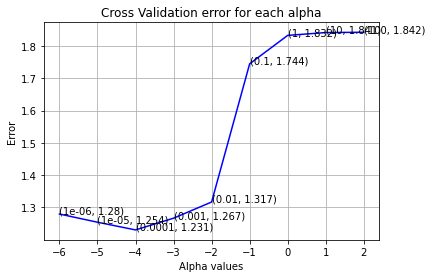

For best alpha value =  0.0001
Train log loss is:  0.3749012651411745
CV log loss is:  1.2305834276442298
Test log loss is:  1.0900977051147014


In [525]:
# on tf-idf encoded

alpha = [10**x for x in range(-6,3)]

def plot_errors(alpha, cv_log_error):
    fig,ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_log_error, c='b')
    for i, txt in enumerate(np.round(cv_log_error, 3)):
        ax.annotate((alpha[i], np.round(txt, 3)), (np.log10(alpha[i]), cv_log_error[i]))
    plt.grid()
    plt.title('Cross Validation error for each alpha')
    plt.xlabel('Alpha values')
    plt.ylabel('Error')
    plt.show()

cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha = i, class_weight='balanced',penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x_tfidf, train_y)
    predict_y = sig_clf.predict_proba(cv_x_tfidf)
    cv_log_error.append(log_loss(cv_y, predict_y, labels=clf.classes_))
    print('For alpha = ', i, ', log loss is: ', log_loss(cv_y, predict_y, labels=clf.classes_))

plot_errors(alpha, cv_log_error)

best_alpha = np.argmin(cv_log_error)
clf.alpha= alpha[best_alpha]
clf.fit(train_x_tfidf, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_tfidf, train_y)

print("For best alpha value = ", alpha[best_alpha])
predict_y = sig_clf.predict_proba(train_x_tfidf)
print("Train log loss is: ", log_loss(train_y, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_tfidf)
print("CV log loss is: ", log_loss(cv_y, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_tfidf)
print("Test log loss is: ", log_loss(y_test, predict_y, labels=clf.classes_))


### On Response Encoded

For alpha =  1e-06 , log loss is:  1.2851382511832052
For alpha =  1e-05 , log loss is:  1.1292730788429586
For alpha =  0.0001 , log loss is:  1.123329605746468
For alpha =  0.001 , log loss is:  1.2080043860192367
For alpha =  0.01 , log loss is:  1.2622189592331514
For alpha =  0.1 , log loss is:  1.2728782567008032
For alpha =  1 , log loss is:  1.3158910660912988
For alpha =  10 , log loss is:  1.5380869469964609
For alpha =  100 , log loss is:  1.579637411702684


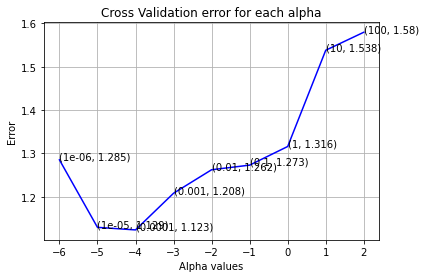

For best alpha value =  0.0001
Train log loss is:  0.8765579522040549
CV log loss is:  1.123329605746468
Test log loss is:  1.13147616642846


In [526]:
# response encoded

alpha = [10**x for x in range(-6,3)]

def plot_errors(alpha, cv_log_error):
    fig,ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_log_error, c='b')
    for i, txt in enumerate(np.round(cv_log_error, 3)):
        ax.annotate((alpha[i], np.round(txt, 3)), (np.log10(alpha[i]), cv_log_error[i]))
    plt.grid()
    plt.title('Cross Validation error for each alpha')
    plt.xlabel('Alpha values')
    plt.ylabel('Error')
    plt.show()

cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha = i, class_weight='balanced',penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_rc, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x_rc, train_y)
    predict_y = sig_clf.predict_proba(cv_x_rc)
    cv_log_error.append(log_loss(cv_y, predict_y, labels=clf.classes_))
    print('For alpha = ', i, ', log loss is: ', log_loss(cv_y, predict_y, labels=clf.classes_))

plot_errors(alpha, cv_log_error)

best_alpha = np.argmin(cv_log_error)
clf.alpha= alpha[best_alpha]
clf.fit(train_x_rc, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_rc, train_y)

print("For best alpha value = ", alpha[best_alpha])
predict_y = sig_clf.predict_proba(train_x_rc)
print("Train log loss is: ", log_loss(train_y, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_rc)
print("CV log loss is: ", log_loss(cv_y, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_rc)
print("Test log loss is: ", log_loss(y_test, predict_y, labels=clf.classes_))


### On OneHot encoded

In [ ]:
# onehot encoded

alpha = [10**x for x in range(-6,3)]

def plot_errors(alpha, cv_log_error):
    fig,ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_log_error, c='b')
    for i, txt in enumerate(np.round(cv_log_error, 3)):
        ax.annotate((alpha[i], np.round(txt, 3)), (np.log10(alpha[i]), cv_log_error[i]))
    plt.grid()
    plt.title('Cross Validation error for each alpha')
    plt.xlabel('Alpha values')
    plt.ylabel('Error')
    plt.show()

cv_log_error = []
for i in alpha:
    clf = SGDClassifier(alpha = i, class_weight='balanced',penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehot, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x_onehot, train_y)
    predict_y = sig_clf.predict_proba(cv_x_onehot)
    cv_log_error.append(log_loss(cv_y, predict_y, labels=clf.classes_))
    print('For alpha = ', i, ', log loss is: ', log_loss(cv_y, predict_y, labels=clf.classes_))

plot_errors(alpha, cv_log_error)

best_alpha = np.argmin(cv_log_error)
clf.alpha= alpha[best_alpha]
clf.fit(train_x_onehot, train_y)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_x_onehot, train_y)

print("For best alpha value = ", alpha[best_alpha])
predict_y = sig_clf.predict_proba(train_x_onehot)
print("Train log loss is: ", log_loss(train_y, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehot)
print("CV log loss is: ", log_loss(cv_y, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehot)
print("Test log loss is: ", log_loss(y_test, predict_y, labels=clf.classes_))


### Summary

- Logistic regression with class balancing on Onehot encoding shows least log-loss value
    - Train data log_loss: 0.50
    - CV data log_loss: 1.14
    - Test data log_loss: 1.05
 
- Compared to the random model, withlog_loss = 2.5, and other models that we trained, Logistic regression shows better performance